### 関係ない

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# # Introduction

# **Based on:**
# 
# https://www.kaggle.com/code/greysky/home-credit-baseline
# 
# 
# **Related notebooks**
# 
# Training model-1 notebook:
# 
# https://www.kaggle.com/andreynesterov/home-credit-baseline-training
# 
# Inference notebook:
# 
# https://www.kaggle.com/andreynesterov/home-credit-baseline-inference

# # Dependencies

# In[ ]:


import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime
import re

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)


# # Configuration

# In[ ]:


class CFG:
    root_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/")
    train_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train")
    test_dir = Path("/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test")


# ## Feature definitions

# In[ ]:


if __name__ == '__main__':
    pd.set_option('max_colwidth', 400)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 500)
    feature_definitions_df = pd.read_csv(CFG.root_dir / "feature_definitions.csv")
    display(feature_definitions_df)
    pd.reset_option("display.max_rows", 0)
    pd.set_option('max_colwidth', 50)


# # Data Collection and Preprocessing

# In[ ]:


### from https://www.kaggle.com/code/batprem/home-credit-risk-mode-utility-scripts

def reduce_mem_usage(df, float16_as32=True):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    if float16_as32:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16)                    
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


# ### Pipeline

# In[ ]:


class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df


# ### Automatic Aggregation

# In[ ]:


class Aggregator:
    def __init__(
        self, 
        num_aggregators=[pl.max, pl.min, pl.first, pl.last, pl.mean], 
        str_aggregators=[pl.max, pl.min, pl.first, pl.last],  # n_unique
        group_aggregators=[pl.max, pl.min, pl.first, pl.last],
        str_mode=True
    ):
        self.num_aggregators = num_aggregators
        self.str_aggregators = str_aggregators
        self.group_aggregators = group_aggregators
        self.str_mode=str_mode
    
    def num_expr(self, df_cols):
        cols = [col for col in df_cols if col[-1] in ("P", "A")]
        expr_all = []
        for method in self.num_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]
            expr_all += expr

        return expr_all

    def date_expr(self, df_cols):
        cols = [col for col in df_cols if col[-1] in ("D",)]
        expr_all = []
        for method in self.num_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all

    def str_expr(self, df_cols):
        cols = [col for col in df_cols if col[-1] in ("M",)]
        
        expr_all = []
        for method in self.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr
            
        if self.str_mode:
            expr_mode = [
                pl.col(col)
                .drop_nulls()
                .mode()
                .first()
                .alias(f"mode_{col}")
                for col in cols
            ]
        else:
            expr_mode = []

        return expr_all + expr_mode

    def other_expr(self, df_cols):
        cols = [col for col in df_cols if col[-1] in ("T", "L")]
        
        expr_all = []
        for method in self.str_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all
    
    def count_expr(self, df_cols):
        cols = [col for col in df_cols if "num_group" in col]

        expr_all = []
        for method in self.group_aggregators:
            expr = [method(col).alias(f"{method.__name__}_{col}") for col in cols]  
            expr_all += expr

        return expr_all

    def get_exprs(self, df_cols):
        exprs = (
            self.num_expr(df_cols) + 
            self.date_expr(df_cols) + 
            self.str_expr(df_cols) + 
            self.other_expr(df_cols) + 
            self.count_expr(df_cols)
        )

        return exprs


# In[ ]:


def read_files_by_path(pattern_path, aggregator, depth=None, agg_chunks=False, num_group1_filter=None):
    chunks = []
    for i, path in enumerate(glob(str(pattern_path))):
        print("  chunk: ", i)
        chunk = pl.read_parquet(path).pipe(Pipeline.set_table_dtypes)
        if agg_chunks:
            if num_group1_filter != None:
                chunk = chunk.filter((pl.col("num_group1") == num_group1_filter)).drop(columns=["num_group1"])
            chunk = chunk.group_by("case_id").agg(aggregatoror.get_exprs(chunk.columns))
        chunks.append(chunk)
    df = pl.concat(chunks, how="vertical_relaxed")
    
    if depth in [1, 2]:
        print(f"  agg, depth {depth}")
        if num_group1_filter != None:
            df = df.filter((pl.col("num_group1") == num_group1_filter)).drop(columns=["num_group1"])
        df = df.group_by("case_id").agg(aggregator.get_exprs(df.columns))
    return df


# In[ ]:


def read_files(files_arr, data_dir, aggregator, mode="train", agg_chunks=False, num_group1_filter=None):
    base_file_name = f"{mode}_base.parquet"
    print("  files: ", base_file_name)
    feats_df = read_files_by_path(
        data_dir / base_file_name, data_dir, mode
    )
    
    for i, file_name in enumerate(files_arr):
        depth = re.findall("\w_(\d)", file_name)
        if len(depth) > 0:
            depth = depth[0]
        else:
            continue
        print("  files: ", file_name, f"(depth: {depth})")
        files_df = read_files_by_path(
            data_dir / f"{mode}{file_name}", 
            aggregator, int(depth), agg_chunks, 
            num_group1_filter=num_group1_filter
        )
        feats_df = feats_df.join(
            files_df, 
            how="left", on="case_id", suffix=f"_{depth}_{i}"
        )
        del files_df
        gc.collect()

    return feats_df


# In[ ]:


def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data


# # Prepare df

# In[ ]:


def prepare_df(
    files_arr, data_dir, aggregator, 
    mode="train", cat_cols=None, train_cols=[], 
    agg_chunks=False, feat_eng=True, num_group1_filter=None
):
    print()
    print("Collecting data...")
    feats_df = read_files(files_arr, data_dir, aggregator, mode=mode, agg_chunks=agg_chunks)
    print("  feats_df shape:\t", feats_df.shape)
    
    if feat_eng:
        print("Feature Engineering...")
        feats_df = feats_df.with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
        neworder = feats_df.columns
        neworder.remove("month_decision")
        neworder.remove("weekday_decision")
        neworder.insert(5, "month_decision")
        neworder.insert(6, "weekday_decision")
        feats_df = feats_df.select(neworder)
    
    feats_df = feats_df.pipe(Pipeline.handle_dates)
#     print("  feats_df shape:\t", feats_df.shape)
    
    print("Filter cols...")
    if mode == "train":
        feats_df = feats_df.pipe(Pipeline.filter_cols)
    else:
        train_cols = feats_df.columns if len(train_cols) == 0 else train_cols
        feats_df = feats_df.select([col for col in train_cols if col != "target"])
    print("  feats_df shape:\t", feats_df.shape)
    
    print("Convert to pandas...")
    feats_df = to_pandas(feats_df, cat_cols)
    return feats_df


# In[ ]:


credit_bureau_a_1_files = [
    "_credit_bureau_a_1_*.parquet",
]
credit_b_a_1_agg = Aggregator(
    num_aggregators = [pl.max, pl.min, pl.first, pl.last, pl.mean],
    str_aggregators = [pl.max, pl.min, pl.first, pl.last], # n_unique
    group_aggregators = [pl.max, pl.min, pl.first, pl.last]
)


# In[ ]:


if __name__ == '__main__':
    credit_bureau_a_1_train_df = prepare_df(
        credit_bureau_a_1_files, CFG.train_dir, credit_b_a_1_agg, feat_eng=False
    )
    gc.collect()
    cat_cols_credit_bureau_a_1 = list(credit_bureau_a_1_train_df.select_dtypes("category").columns)
    display(credit_bureau_a_1_train_df)


# In[ ]:


credit_bureau_a_2_files = [
    "_credit_bureau_a_2_*.parquet",
]
credit_b_a_2_agg = Aggregator(
    num_aggregators = [pl.first],
    str_aggregators = [pl.first],
    group_aggregators = [pl.first],
    str_mode = False
)
credit_b_a_2_agg_2 = Aggregator(
    num_aggregators = [pl.max],
    str_aggregators = [pl.max],
    group_aggregators = [pl.max],
    str_mode = False
)


# In[ ]:


if __name__ == '__main__':
    credit_bureau_a_2_train_df = prepare_df(
        credit_bureau_a_2_files, CFG.train_dir, credit_b_a_2_agg, agg_chunks=True, feat_eng=False
    )
    
    credit_bureau_a_2_train_df_2 = prepare_df(
        credit_bureau_a_2_files, CFG.train_dir, credit_b_a_2_agg_2, agg_chunks=True, feat_eng=False
    )
    credit_bureau_a_2_train_df_2.set_index("case_id", inplace=True)
    
    credit_bureau_a_2_train_df = credit_bureau_a_2_train_df.join(
        credit_bureau_a_2_train_df_2.drop(columns=["WEEK_NUM", "target"]), 
        how="left", on="case_id"
    )
    
    cat_cols_credit_bureau_a_2 = list(credit_bureau_a_2_train_df.select_dtypes("category").columns)
    del credit_bureau_a_2_train_df_2
    gc.collect()
    display(credit_bureau_a_2_train_df)


# In[ ]:


if __name__ == '__main__':
    display(credit_bureau_a_2_train_df.describe())


# In[ ]:


if __name__ == '__main__':
    display(credit_bureau_a_2_train_df[credit_bureau_a_2_train_df.case_id == 405])


# In[ ]:


base_files = [
    "_static_cb_0.parquet",
    "_static_0_*.parquet",
    "_applprev_1_*.parquet",
    "_tax_registry_a_1.parquet",
    "_tax_registry_b_1.parquet",
    "_tax_registry_c_1.parquet",
    "_other_1.parquet",
    "_person_1.parquet",
    "_deposit_1.parquet",
    "_debitcard_1.parquet",
    "_credit_bureau_b_1.parquet",
    "_credit_bureau_b_2.parquet",
]
base_agg = Aggregator(
    num_aggregators = [pl.max, pl.min, pl.first, pl.last, pl.mean],
    str_aggregators = [pl.max, pl.min, pl.first, pl.last],
    group_aggregators = [pl.max, pl.min, pl.first, pl.last],
    str_mode = True
)


# In[ ]:


if __name__ == '__main__':
    train_base_df = prepare_df(base_files, CFG.train_dir, base_agg)
    cat_cols_base = list(train_base_df.select_dtypes("category").columns)
    display(train_base_df)


# In[ ]:


if __name__ == '__main__':
    display(cat_cols_base)


# In[ ]:


if __name__ == '__main__':
    test_base_df = prepare_df(
        base_files, CFG.test_dir, base_agg, mode="test", cat_cols=cat_cols_base, train_cols=train_base_df.columns
    )
    display(test_base_df)


# # Save files

# In[ ]:


if __name__ == '__main__':
    train_base_df.to_parquet("train_base.parquet")
    credit_bureau_a_1_train_df.to_parquet("credit_bureau_a_1_train_df.parquet")
    credit_bureau_a_2_train_df.to_parquet("credit_bureau_a_2_train_df.parquet")


# ### EDA

# In[ ]:


if __name__ == '__main__':
    print("Train is duplicated:\t", train_base_df["case_id"].duplicated().any())
    print("Train Week Range:\t", (train_base_df["WEEK_NUM"].min(), train_base_df["WEEK_NUM"].max()))

    print()

    print("Test is duplicated:\t", test_base_df["case_id"].duplicated().any())
    print("Test Week Range:\t", (test_base_df["WEEK_NUM"].min(), test_base_df["WEEK_NUM"].max()))


# In[ ]:


if __name__ == '__main__':
    sns.lineplot(
        data=train_base_df,
        x="WEEK_NUM",
        y="target",
    )
    plt.show()


### 本編

In [ ]:
# https://www.kaggle.com/code/mariushinsberger/xgboost-on-obesity-risk

In [9]:
import os
import gc
import re
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin

import joblib

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
import shap

In [11]:
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import scipy.stats as stats
import optuna
from optuna.samplers import TPESampler

## Pre-Fitted Voting Model

In [12]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

## Pipeline

In [13]:
class Pipeline:
    # カラムのキャストを行うメソッド
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean() # nullの個数の平均値（null率）を算出

                if isnull > 0.95:
                    df = df.drop(col) # null率が95%以上なら、カラムを削除

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique() # ユニーク数をカウント

                if (freq == 1) | (freq > 200): # ユニーク数が1 または 200以上なら、カラムを削除（理由不明）
                    df = df.drop(col)

        return df

## Automatic Aggregation

In [14]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

## File I/O

In [15]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes) # カラムのキャスト
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        chunks.append(pl.read_parquet(path).pipe(Pipeline.set_table_dtypes))
        
    df = pl.concat(chunks, how="vertical_relaxed")
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

## Feature Engineering

In [16]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [17]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols

## Configuration

In [18]:
ROOT            = Path("../dataset")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

## Train Files Read & Feature Engineering

In [19]:
del data_store
del df_train

NameError: name 'data_store' is not defined

In [20]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
    ]
}

In [21]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 376)


## Test Files Read & Feature Engineering

In [11]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
    ]
}

In [12]:
df_test = feature_eng(**data_store)

print("test data shape:\t", df_test.shape)

test data shape:	 (10, 375)


## EDA

### EDA

In [15]:
train, cat_cols = to_pandas(df_train)
test, cat_cols = to_pandas(df_test, cat_cols)

NameError: name 'df_test' is not defined

In [14]:
print(f"The training dataset consists of {train.shape[0]} rows and {train.shape[1]} columns.")
print(f"The test dataset consists of {test.shape[0]} rows and {test.shape[1]} columns.")

The training dataset consists of 1526659 rows and 376 columns.
The test dataset consists of 10 rows and 375 columns.


In [15]:
train.columns

Index(['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision',
       'assignmentdate_238D', 'assignmentdate_4527235D',
       'assignmentdate_4955616D', 'birthdate_574D', 'contractssum_5085716L',
       ...
       'max_last180dayaveragebalance_704A', 'max_last180dayturnover_1134A',
       'max_last30dayturnover_651A', 'max_openingdate_857D',
       'max_num_group1_10', 'max_pmts_dpdvalue_108P',
       'max_pmts_pmtsoverdue_635A', 'max_pmts_date_1107D', 'max_num_group1_11',
       'max_num_group2'],
      dtype='object', length=376)

In [16]:
"target" in list(train.columns)

True

In [17]:
train.head().T

,0,1,2,3,4
case_id,0,1,2,3,4
WEEK_NUM,0,0,0,0,0
target,0,0,0,0,1
month_decision,1,1,1,1,1
weekday_decision,4,4,5,4,5
...,...,...,...,...,...
max_pmts_dpdvalue_108P,NaN,NaN,NaN,NaN,NaN
max_pmts_pmtsoverdue_635A,NaN,NaN,NaN,NaN,NaN
max_pmts_date_1107D,NaN,NaN,NaN,NaN,NaN
max_num_group1_11,NaN,NaN,NaN,NaN,NaN


In [18]:
train.tail().T

,1526654,1526655,1526656,1526657,1526658
case_id,2703450,2703451,2703452,2703453,2703454
WEEK_NUM,91,91,91,91,91
target,0,0,0,0,0
month_decision,10,10,10,10,10
weekday_decision,1,1,1,1,1
...,...,...,...,...,...
max_pmts_dpdvalue_108P,NaN,NaN,NaN,NaN,NaN
max_pmts_pmtsoverdue_635A,NaN,NaN,NaN,NaN,NaN
max_pmts_date_1107D,NaN,NaN,NaN,NaN,NaN
max_num_group1_11,NaN,NaN,NaN,NaN,NaN


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Columns: 376 entries, case_id to max_num_group2
dtypes: bool(1), category(84), float64(284), int64(5), int8(2)
memory usage: 3.4 GB


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Columns: 375 entries, case_id to max_num_group2
dtypes: bool(1), category(84), float64(285), int64(3), int8(2)
memory usage: 33.0 KB


### Missing values

In [21]:
train.isna().sum()

case_id                            0
WEEK_NUM                           0
target                             0
month_decision                     0
weekday_decision                   0
                              ...   
max_pmts_dpdvalue_108P       1490244
max_pmts_pmtsoverdue_635A    1490244
max_pmts_date_1107D          1490212
max_num_group1_11            1490212
max_num_group2               1490212
Length: 376, dtype: int64

In [22]:
test.isna().sum()

case_id                       0
WEEK_NUM                      0
month_decision                0
weekday_decision              0
assignmentdate_238D          10
                             ..
max_pmts_dpdvalue_108P       10
max_pmts_pmtsoverdue_635A    10
max_pmts_date_1107D          10
max_num_group1_11            10
max_num_group2               10
Length: 375, dtype: int64

### Find duplicates

In [16]:
print(f"There are {train.duplicated().sum()} duplicates in the train data.")
print(f"There are {test.duplicated().sum()} duplicates in the test data.")
train.drop_duplicates(inplace=True)

There are 0 duplicates in the train data.


NameError: name 'test' is not defined

### Target analysis

In [23]:
target = train["target"]
train2 = train.drop(columns=["case_id", "target"])
test_id = test["case_id"]
test2 = test.drop(columns=["case_id"])

NameError: name 'test' is not defined

In [25]:
target.head()

0    0
1    0
2    0
3    0
4    1
Name: target, dtype: int64

In [26]:
target.value_counts(ascending=False)

target
0    1478665
1      47994
Name: count, dtype: int64

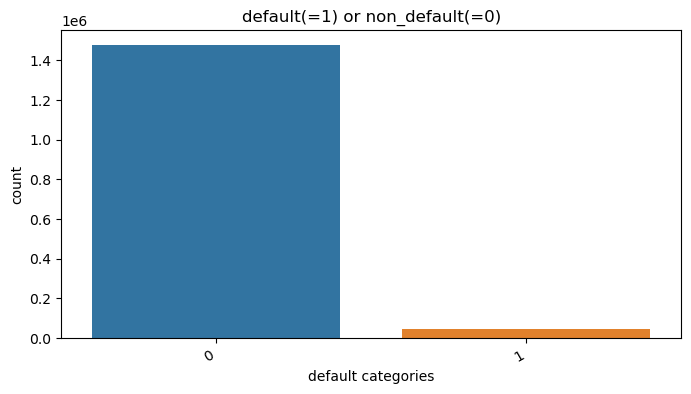

In [24]:
plt.figure(figsize=(8,4))
target_categories = ['default',"non_default"]
target_categories = [0, 1]
ax = sns.countplot(x=target, order=target_categories)
plt.title("default(=1) or non_default(=0)")
plt.xlabel("default categories")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")
plt.show()

### Feature analysis

In [28]:
categorical_features = train.select_dtypes(include=["object"]).columns
numerical_features = train.select_dtypes(include=["int64", "float64"]).columns

In [82]:
len(train.select_dtypes(include=["object","category"]).columns)

84

In [19]:
f1 = [] # 質的変数
f2 = [] # 量的変数
f3 = [] # 日付変数
f4 = [] # 日付差変数
f5 = [] # 未指定変数1
f6 = [] # 未指定変数2

categorical = train.select_dtypes(include=["object","category"]).columns
# 特徴量の分類
for col in train.columns:
#     print(col)
    if (re.fullmatch(r'[a-z]*_\d*M', col, flags=0)) or (col in categorical): # 質的変数
        f1.append(col)
    elif re.fullmatch(r'[a-z]*_\d*A', col, flags=0): # 量的変数
        f2.append(col)
    elif re.fullmatch(r'[a-z]*_\d*D', col, flags=0): # 日付変数
        f3.append(col)
    elif re.fullmatch(r'[a-z]*_\d*P', col, flags=0): # 日付差変数
        f4.append(col)
    elif re.fullmatch(r'[a-z]*_\d*T', col, flags=0): # 未指定変数1
        f5.append(col)
    elif re.fullmatch(r'[a-z]*_\d*L', col, flags=0): # 未指定変数2
        f6.append(col)

features = {}
features['categorical_features'] = f1 # 質的変数
features['numerical_features'] = f2 # 量的変数
features['date_features'] = f3 # 日付変数
features['dpd_features'] = f4 # 日付差変数
features['unspecified1_features'] = f5 # 未指定変数1
features['unspecified2_features'] = f6 # 未指定変数2

# カウント
for k,v in features.items():
    print(f'[{k}]_num = {len(v)}')

[categorical_features]_num = 84
[numerical_features]_num = 24
[date_features]_num = 23
[dpd_features]_num = 3
[unspecified1_features]_num = 1
[unspecified2_features]_num = 75


In [84]:
for feature in features['categorical_features']:
    print(f"{feature}: {train[feature].unique()}")
    if feature == "target": continue
    print(f"{feature}: {test[feature].unique()}")    

description_5085714M: [NaN, 'a55475b1', '2fc785b2']
Categories (2, object): ['2fc785b2', 'a55475b1']
description_5085714M: ['2fc785b2', 'a55475b1']
Categories (2, object): ['2fc785b2', 'a55475b1']
education_1103M: [NaN, 'a55475b1', '717ddd49', '6b2ae0fa', '39a0853f', 'c8e1a1d0']
Categories (5, object): ['39a0853f', '6b2ae0fa', '717ddd49', 'a55475b1', 'c8e1a1d0']
education_1103M: ['a55475b1', '6b2ae0fa']
Categories (2, object): ['6b2ae0fa', 'a55475b1']
education_88M: [NaN, 'a55475b1', '6b2ae0fa', '717ddd49', 'a34a13c8', 'c8e1a1d0']
Categories (5, object): ['6b2ae0fa', '717ddd49', 'a34a13c8', 'a55475b1', 'c8e1a1d0']
education_88M: ['a55475b1']
Categories (1, object): ['a55475b1']
maritalst_385M: [NaN, 'a55475b1', 'a7fcb6e5', '3439d993', 'b6cabe76', '38c061ee', 'ecd83604']
Categories (6, object): ['3439d993', '38c061ee', 'a55475b1', 'a7fcb6e5', 'b6cabe76', 'ecd83604']
maritalst_385M: ['a55475b1', 'b6cabe76', '3439d993']
Categories (3, object): ['3439d993', 'a55475b1', 'b6cabe76']
maritals

max_contracttype_653M: [NaN, '724be82a', 'f4e17141', '1c9c5356', 'a55475b1', ..., 'ef77dd46', '735d178d', '4fe69f1a', '5102da75', 'a46b6619']
Length: 23
Categories (22, object): ['07162370', '1bc8994b', '1c9c5356', '249fb461', ..., 'c6678a8f', 'e730315b', 'ef77dd46', 'f4e17141']
max_contracttype_653M: [NaN]
Categories (0, object): []
max_credor_3940957M: [NaN, 'c5a72b57', 'b619fa46', 'b75a09a4', 'a55475b1', ..., 'd6eab789', 'fa89e91a', 'ed8b8a04', '2b8aed27', 'b0ab3b95']
Length: 96
Categories (95, object): ['00a59564', '01fe039f', '0aebc0bb', '101a8c3a', ..., 'fa89e91a', 'fbb92011', 'fdbe5d79', 'ff11387f']
max_credor_3940957M: [NaN]
Categories (0, object): []
max_periodicityofpmts_997M: [NaN, 'a55475b1', 'd479a207', 'a0b598e4', '842dca9f', '3ecc50a0', 'e4c51201', 'f50a4e2c', 'e24bdef1', '9c7cbdb6']
Categories (9, object): ['3ecc50a0', '842dca9f', '9c7cbdb6', 'a0b598e4', ..., 'd479a207', 'e24bdef1', 'e4c51201', 'f50a4e2c']
max_periodicityofpmts_997M: [NaN]
Categories (0, object): []
max

description_5085714M


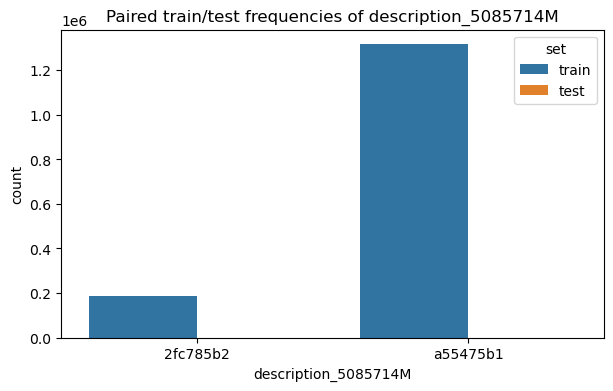

education_1103M


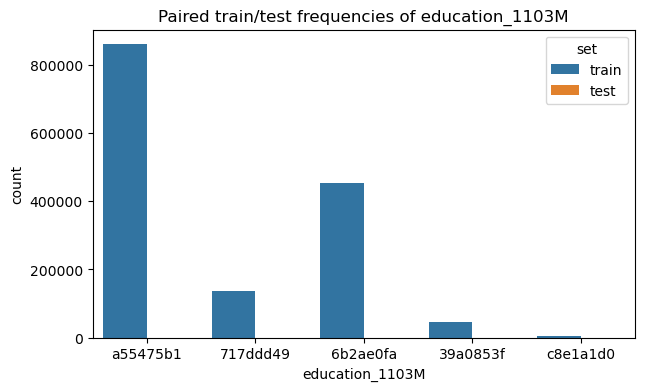

education_88M


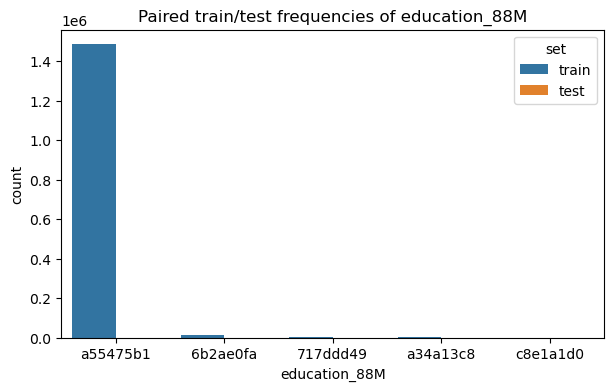

maritalst_385M


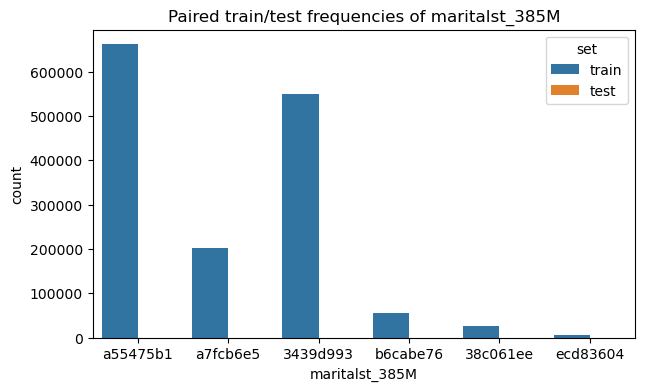

maritalst_893M


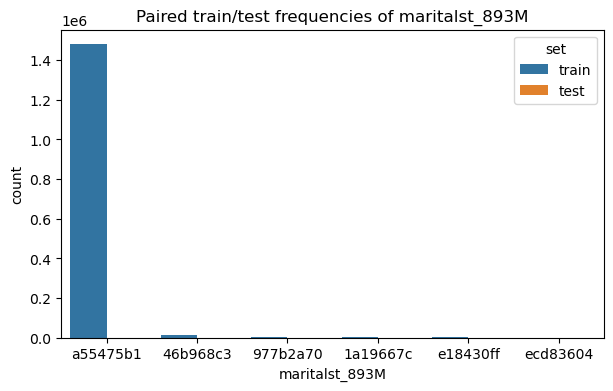

lastapprcommoditycat_1041M


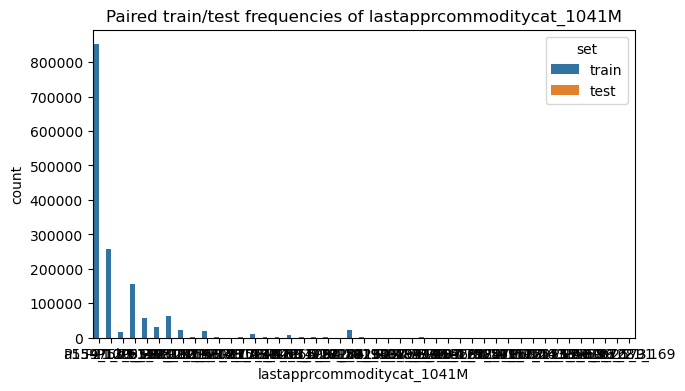

lastapprcommoditytypec_5251766M


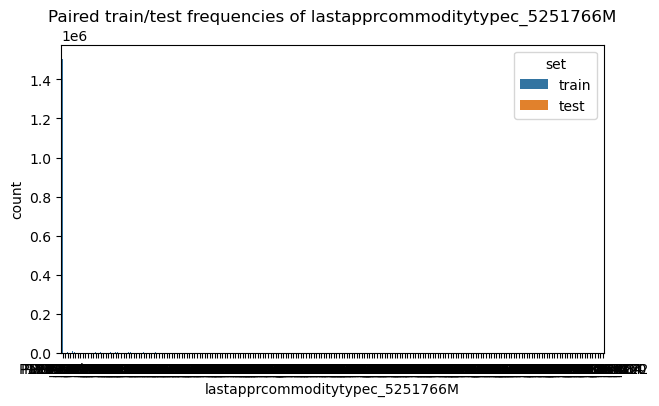

lastcancelreason_561M


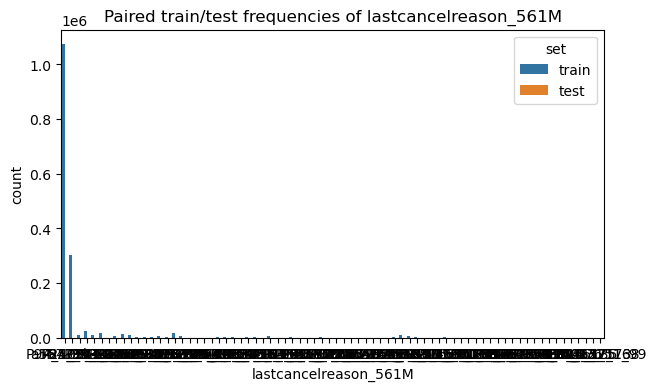

lastrejectcommoditycat_161M


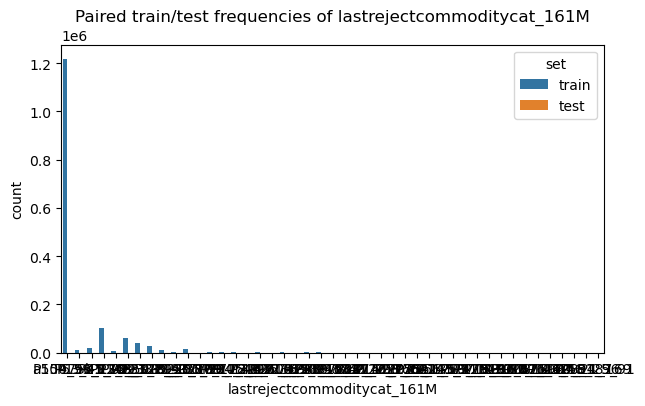

lastrejectcommodtypec_5251769M


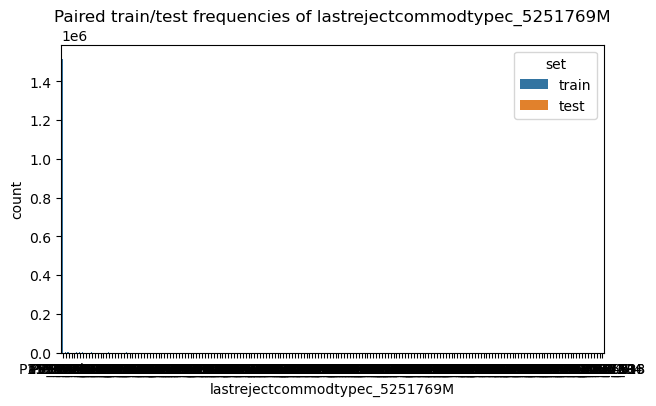

lastrejectreason_759M


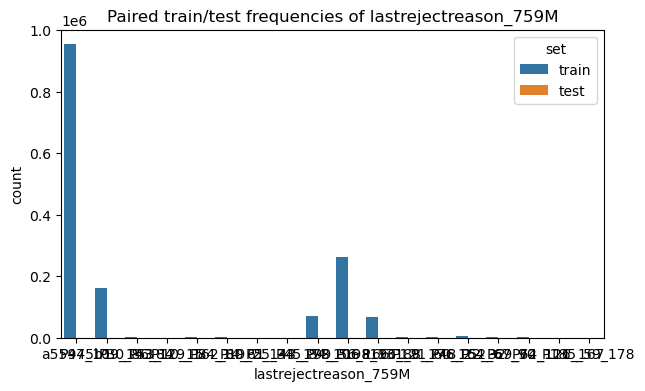

lastrejectreasonclient_4145040M


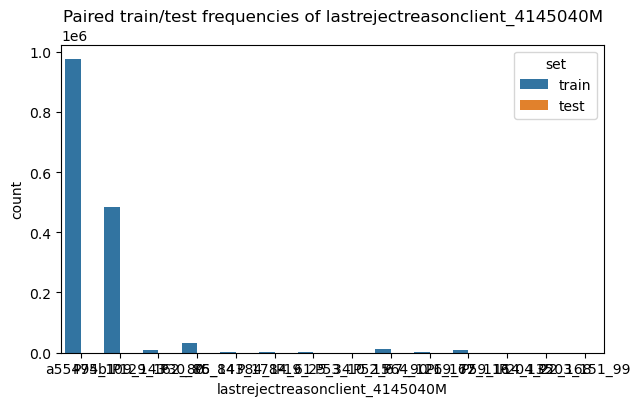

previouscontdistrict_112M


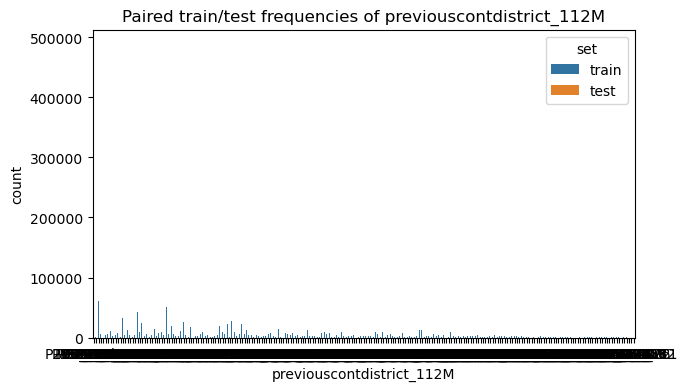

In [129]:
# 原文
def plot_count_pairs(train, test, feature, hue="set"):
    df = train[[feature]].copy()
    df["set"] = "train"
    df = pd.concat([df, test[[feature]].copy()])
    df['set'] = df['set'].fillna('test')
    
    f, ax = plt.subplots(1, 1, figsize=(7, 4))
    sns.countplot(data=df, x=feature, hue=hue)
    ax.set_title(f"Paired train/test frequencies of {feature}")
    plt.show()

for feature in features['categorical_features']:
    if feature == "target": continue
    print(feature)
    plot_count_pairs(train, test, feature)

===description_5085714M===
nan:: 0_num = 0, 1_num = 0, per = 0.0
a55475b1:: 0_num = 1272847, 1_num = 43278, per = 0.034000917627242215
2fc785b2:: 0_num = 180414, 1_num = 3937, per = 0.021821910595017043


C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


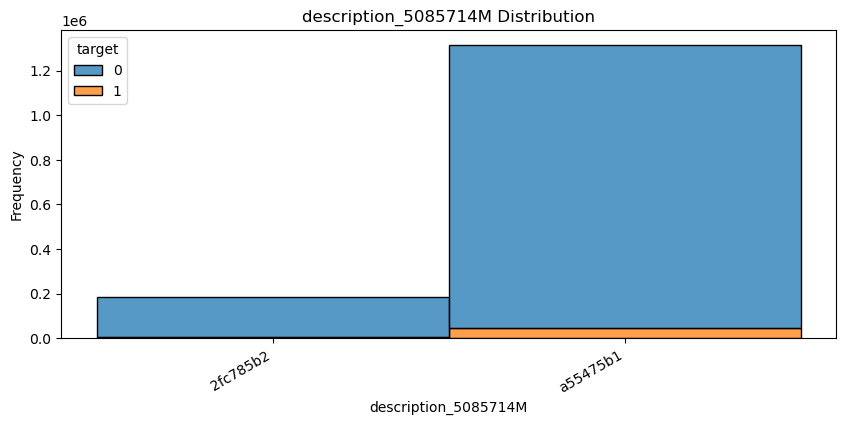

===education_1103M===
nan:: 0_num = 0, 1_num = 0, per = 0.0
a55475b1:: 0_num = 831418, 1_num = 28544, per = 0.03433166670475416
717ddd49:: 0_num = 130902, 1_num = 4440, per = 0.03391824480722367
6b2ae0fa:: 0_num = 440998, 1_num = 11451, per = 0.025966045274479082
39a0853f:: 0_num = 44565, 1_num = 2575, per = 0.05777947314095948
c8e1a1d0:: 0_num = 5378, 1_num = 205, per = 0.03811117308049823


C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


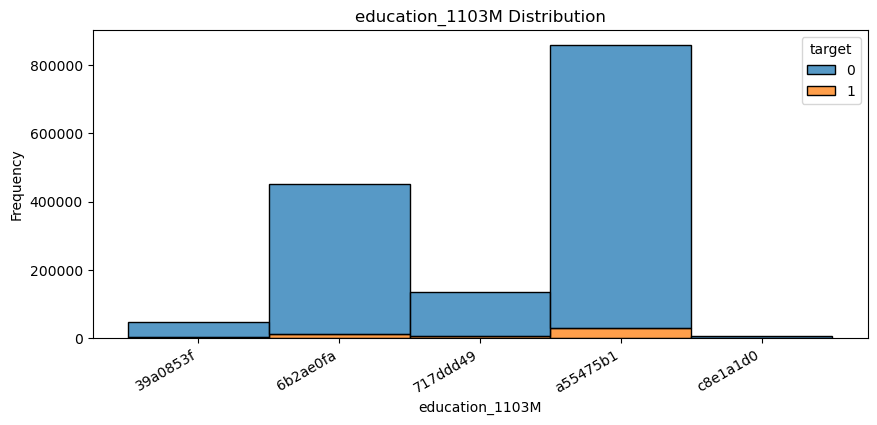

===education_88M===
nan:: 0_num = 0, 1_num = 0, per = 0.0
a55475b1:: 0_num = 1438516, 1_num = 46444, per = 0.03228602790234665
6b2ae0fa:: 0_num = 11144, 1_num = 529, per = 0.0474652310453118
717ddd49:: 0_num = 3076, 1_num = 204, per = 0.06629834254143646
a34a13c8:: 0_num = 407, 1_num = 30, per = 0.07352941176470588
c8e1a1d0:: 0_num = 118, 1_num = 8, per = 0.06722689075630252


C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


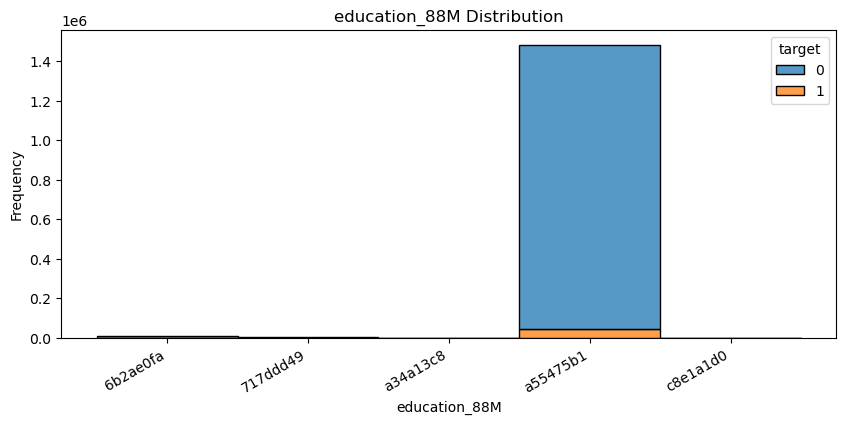

===maritalst_385M===
nan:: 0_num = 0, 1_num = 0, per = 0.0
a55475b1:: 0_num = 639627, 1_num = 21965, per = 0.03434027278355544
a7fcb6e5:: 0_num = 193806, 1_num = 7244, per = 0.03737739090951307
3439d993:: 0_num = 534834, 1_num = 15502, per = 0.02898464012265465
b6cabe76:: 0_num = 54468, 1_num = 1432, per = 0.026290183407075583
38c061ee:: 0_num = 26010, 1_num = 841, per = 0.0323324747222329
ecd83604:: 0_num = 4516, 1_num = 231, per = 0.05114013725924286


C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


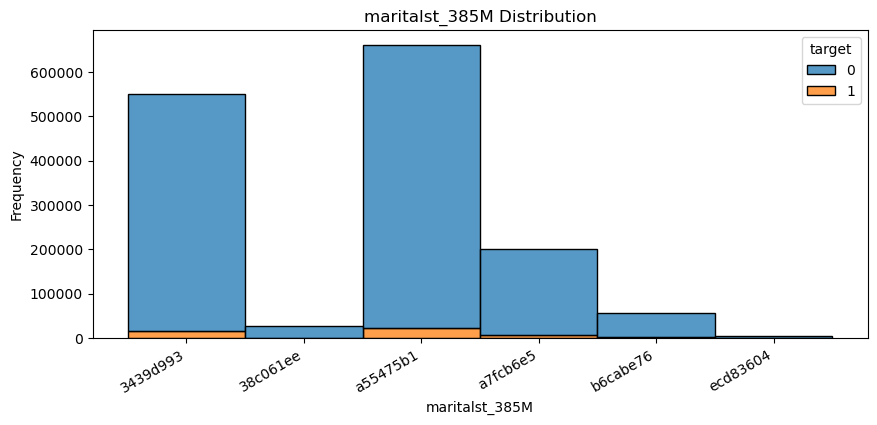

===maritalst_893M===
nan:: 0_num = 0, 1_num = 0, per = 0.0
a55475b1:: 0_num = 1433198, 1_num = 46105, per = 0.0321692940059266
46b968c3:: 0_num = 13211, 1_num = 678, per = 0.05131698455949137
977b2a70:: 0_num = 1148, 1_num = 48, per = 0.04177545691906005
1a19667c:: 0_num = 4978, 1_num = 343, per = 0.06888933520787306
e18430ff:: 0_num = 642, 1_num = 36, per = 0.05598755832037325
ecd83604:: 0_num = 84, 1_num = 5, per = 0.058823529411764705


C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


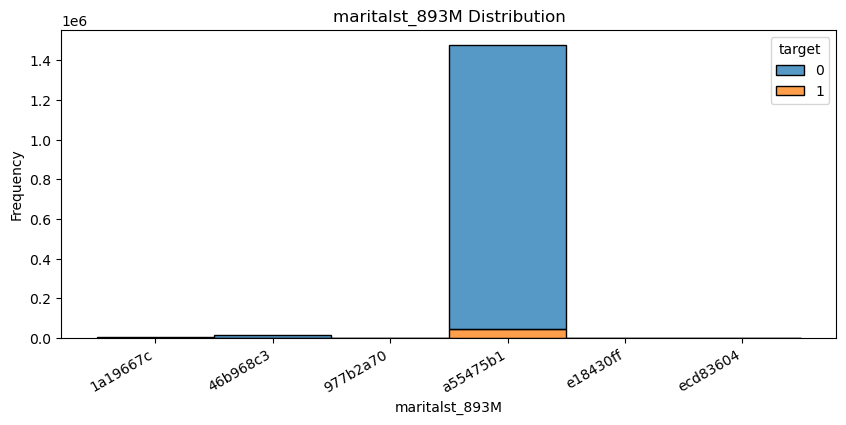

===lastapprcommoditycat_1041M===
a55475b1:: 0_num = 825762, 1_num = 26484, per = 0.03207215629666139
P159_130_59:: 0_num = 247047, 1_num = 9459, per = 0.038288105955118036
P21_79_33:: 0_num = 16983, 1_num = 543, per = 0.03197126707489402
P12_6_178:: 0_num = 151801, 1_num = 4256, per = 0.02803652125795444
P109_133_183:: 0_num = 54944, 1_num = 1449, per = 0.026371826371826373
P53_45_92:: 0_num = 30396, 1_num = 906, per = 0.029805572918380104
P148_110_5:: 0_num = 61387, 1_num = 1931, per = 0.03145565908646641
P33_29_177:: 0_num = 20340, 1_num = 631, per = 0.03102109040853449
P201_79_148:: 0_num = 2293, 1_num = 76, per = 0.03312990409764603
P100_96_175:: 0_num = 17645, 1_num = 329, per = 0.018644452000453362
P216_109_183:: 0_num = 1494, 1_num = 57, per = 0.03812709030100334
P143_21_170:: 0_num = 114, 1_num = 4, per = 0.034782608695652174
P187_118_47:: 0_num = 2642, 1_num = 98, per = 0.037079076806659096
P128_43_169:: 0_num = 9611, 1_num = 265, per = 0.02756970453599667
P177_46_174:: 0_num 

C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


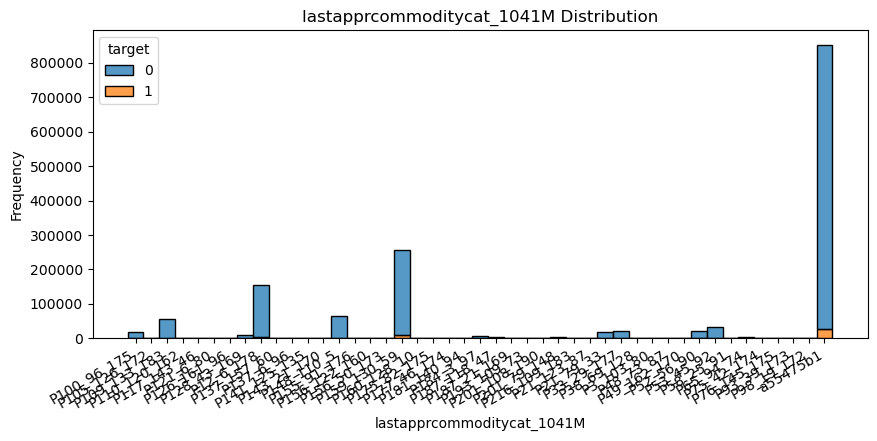

===lastapprcommoditytypec_5251766M===
a55475b1:: 0_num = 1456109, 1_num = 47548, per = 0.03265412640528532
P126_18_172:: 0_num = 115, 1_num = 3, per = 0.02586206896551724
P165_57_169:: 0_num = 481, 1_num = 7, per = 0.014522821576763486
P70_143_178:: 0_num = 58, 1_num = 3, per = 0.05084745762711865
P75_90_70:: 0_num = 6993, 1_num = 161, per = 0.02301973119816986
P174_113_42:: 0_num = 1001, 1_num = 24, per = 0.023952095808383235
P30_45_143:: 0_num = 383, 1_num = 9, per = 0.0234375
P123_124_181:: 0_num = 412, 1_num = 5, per = 0.012106537530266344
P170_96_161:: 0_num = 20, 1_num = 0, per = 0.0
P49_111_165:: 0_num = 164, 1_num = 5, per = 0.030303030303030304
P206_72_67:: 0_num = 264, 1_num = 5, per = 0.018867924528301886
P161_88_182:: 0_num = 401, 1_num = 12, per = 0.029850746268656716
P135_89_156:: 0_num = 284, 1_num = 5, per = 0.017543859649122806
P79_131_167:: 0_num = 929, 1_num = 16, per = 0.017204301075268817
P97_89_62:: 0_num = 28, 1_num = 0, per = 0.0
P200_75_140:: 0_num = 629, 1_num

P86_63_168:: 0_num = 2, 1_num = 0, per = 0.0
P13_114_11:: 0_num = 1, 1_num = 0, per = 0.0
P110_47_170:: 0_num = 2, 1_num = 0, per = 0.0
P10_154_146:: 0_num = 1, 1_num = 0, per = 0.0
P210_17_167:: 0_num = 1, 1_num = 0, per = 0.0
P132_44_167:: 0_num = 1, 1_num = 0, per = 0.0
P125_108_82:: 0_num = 2, 1_num = 0, per = 0.0
P7_14_175:: 0_num = 1, 1_num = 0, per = 0.0
P126_100_56:: 0_num = 1, 1_num = 0, per = 0.0
P140_2_44:: 0_num = 1, 1_num = 0, per = 0.0
P22_46_79:: 0_num = 1, 1_num = 0, per = 0.0
P79_44_171:: 0_num = 1, 1_num = 0, per = 0.0
P56_22_57:: 0_num = 2, 1_num = 0, per = 0.0
P194_143_7:: 0_num = 2, 1_num = 0, per = 0.0
P100_118_186:: 0_num = 3, 1_num = 0, per = 0.0
P38_126_100:: 0_num = 2, 1_num = 0, per = 0.0
P94_125_186:: 0_num = 1, 1_num = 0, per = 0.0
P61_95_106:: 0_num = 1, 1_num = 0, per = 0.0
P153_135_166:: 0_num = 1, 1_num = 0, per = 0.0
P125_63_164:: 0_num = 1, 1_num = 0, per = 0.0
P168_77_175:: 0_num = 2, 1_num = 0, per = 0.0
P89_148_176:: 0_num = 1, 1_num = 0, per = 0.0

C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


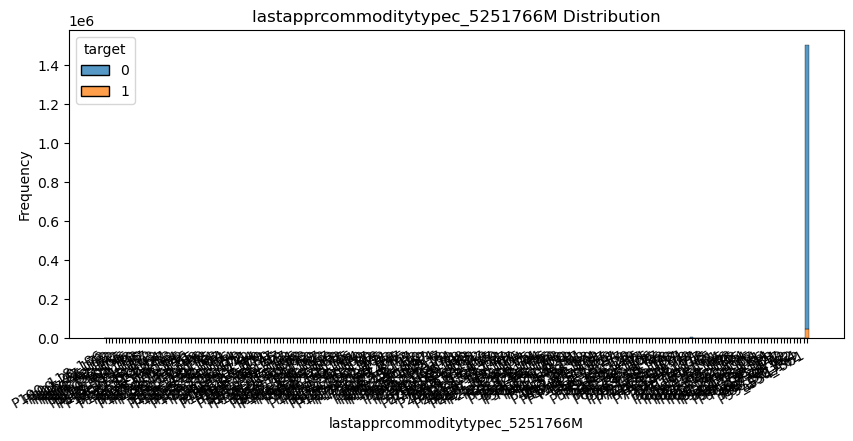

===lastcancelreason_561M===
a55475b1:: 0_num = 1047770, 1_num = 26283, per = 0.025084679763039824
P94_109_143:: 0_num = 284291, 1_num = 16506, per = 0.05806002279346587
P24_27_36:: 0_num = 10690, 1_num = 551, per = 0.05153867739219905
P85_114_140:: 0_num = 22531, 1_num = 618, per = 0.027427658441327888
P73_130_169:: 0_num = 10506, 1_num = 219, per = 0.02084324735890359
P30_86_84:: 0_num = 16356, 1_num = 910, per = 0.055633673656538485
P53_10_15:: 0_num = 150, 1_num = 10, per = 0.06622516556291391
P141_135_146:: 0_num = 4810, 1_num = 185, per = 0.038453543961754315
P180_60_137:: 0_num = 11857, 1_num = 288, per = 0.024287400910777534
P11_56_131:: 0_num = 7439, 1_num = 239, per = 0.0321236559139785
P32_163_96:: 0_num = 3236, 1_num = 89, per = 0.027494593759654
P46_50_166:: 0_num = 1703, 1_num = 71, per = 0.041666666666666664
P98_38_170:: 0_num = 1318, 1_num = 69, per = 0.052312357846853674
P129_162_80:: 0_num = 4596, 1_num = 323, per = 0.0702632151403089
P120_0_10:: 0_num = 1674, 1_num = 

C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


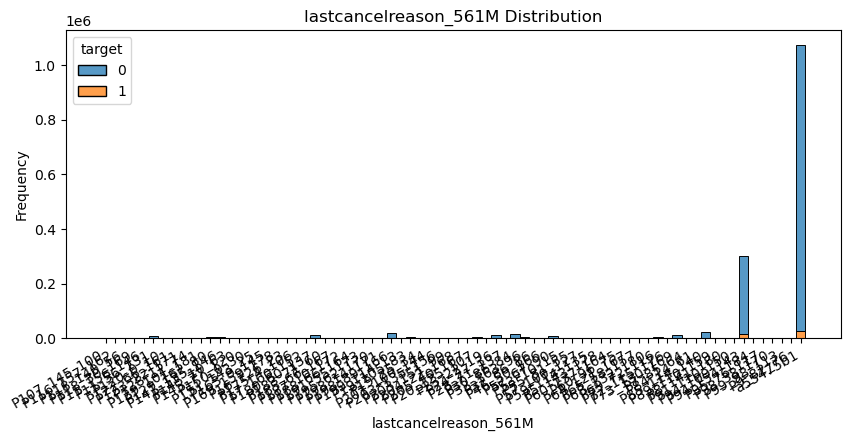

===lastrejectcommoditycat_161M===
a55475b1:: 0_num = 1179983, 1_num = 36002, per = 0.0305105831943484
P100_96_175:: 0_num = 9307, 1_num = 172, per = 0.01847872797593468
P53_45_92:: 0_num = 18665, 1_num = 597, per = 0.03198328511732562
P159_130_59:: 0_num = 98346, 1_num = 5251, per = 0.053392579336431205
P21_79_33:: 0_num = 6353, 1_num = 219, per = 0.03446647780925401
P12_6_178:: 0_num = 59922, 1_num = 2021, per = 0.03372661582364034
P148_110_5:: 0_num = 39609, 1_num = 1513, per = 0.03819742489270386
P109_133_183:: 0_num = 26861, 1_num = 839, per = 0.03123371305189487
P33_29_177:: 0_num = 9167, 1_num = 327, per = 0.035667539267015706
P128_43_169:: 0_num = 3521, 1_num = 114, per = 0.03236797274275979
P52_56_90:: 0_num = 16153, 1_num = 474, per = 0.029342577689736287
P193_109_73:: 0_num = 203, 1_num = 7, per = 0.03431372549019608
P201_79_148:: 0_num = 697, 1_num = 39, per = 0.055873925501432664
P187_118_47:: 0_num = 1870, 1_num = 31, per = 0.016568679850347406
P184_3_97:: 0_num = 2847, 1_

C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


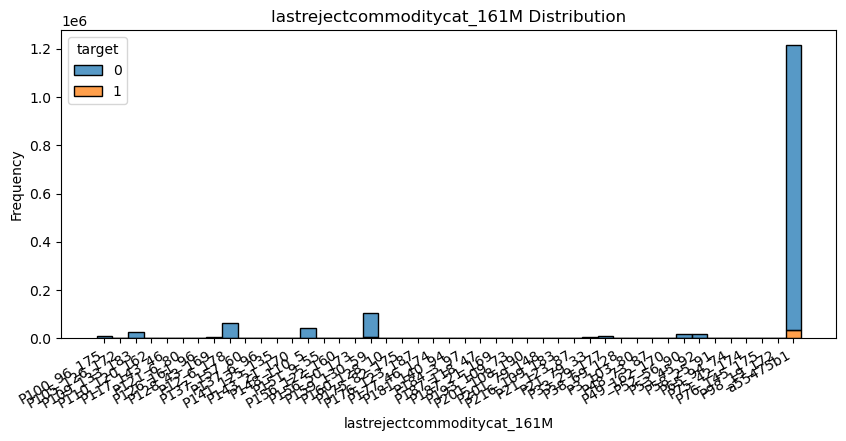

===lastrejectcommodtypec_5251769M===
a55475b1:: 0_num = 1466156, 1_num = 47691, per = 0.03252789435237836
P111_89_135:: 0_num = 920, 1_num = 20, per = 0.021715526601520086
P75_90_70:: 0_num = 3316, 1_num = 113, per = 0.03406692794694001
P5_163_186:: 0_num = 21, 1_num = 0, per = 0.0
P128_13_121:: 0_num = 204, 1_num = 6, per = 0.02926829268292683
P108_95_156:: 0_num = 617, 1_num = 10, per = 0.016181229773462782
P95_36_171:: 0_num = 524, 1_num = 11, per = 0.02095238095238095
P174_113_42:: 0_num = 514, 1_num = 16, per = 0.031067961165048542
P135_89_156:: 0_num = 113, 1_num = 4, per = 0.03508771929824561
P165_57_169:: 0_num = 363, 1_num = 0, per = 0.0
P172_87_177:: 0_num = 514, 1_num = 9, per = 0.017475728155339806
P136_59_154:: 0_num = 195, 1_num = 4, per = 0.02040816326530612
P34_45_168:: 0_num = 12, 1_num = 0, per = 0.0
P126_18_172:: 0_num = 66, 1_num = 1, per = 0.014925373134328358
P185_44_170:: 0_num = 2, 1_num = 0, per = 0.0
P200_75_140:: 0_num = 394, 1_num = 7, per = 0.01772151898734

C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


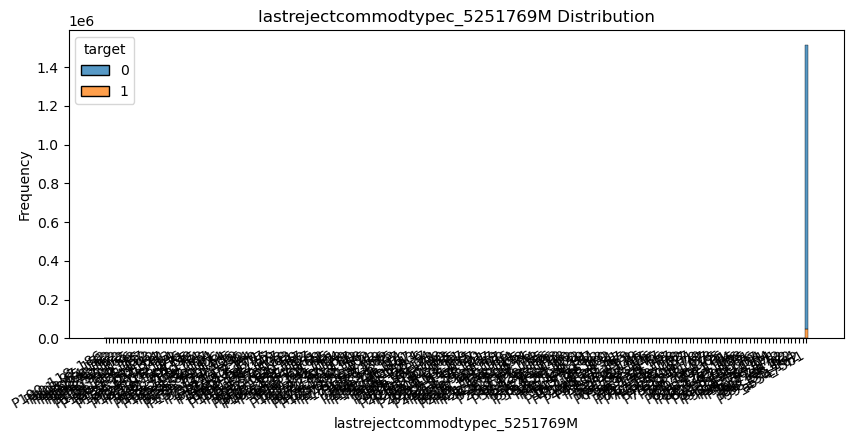

===lastrejectreason_759M===
a55475b1:: 0_num = 932541, 1_num = 21114, per = 0.022641339478543594
P94_109_143:: 0_num = 154481, 1_num = 7045, per = 0.045604018591162726
P30_86_84:: 0_num = 2409, 1_num = 76, per = 0.03153526970954357
P53_10_15:: 0_num = 63, 1_num = 8, per = 0.125
P129_162_80:: 0_num = 341, 1_num = 24, per = 0.07017543859649122
P84_14_61:: 0_num = 362, 1_num = 12, per = 0.03305785123966942
P19_25_34:: 0_num = 90, 1_num = 0, per = 0.0
P5_143_178:: 0_num = 65, 1_num = 7, per = 0.10606060606060606
P45_84_106:: 0_num = 63405, 1_num = 6175, per = 0.09738825978614012
P99_56_166:: 0_num = 251686, 1_num = 10909, per = 0.04334351794093457
P198_131_9:: 0_num = 65102, 1_num = 2284, per = 0.03508286868500683
P196_88_176:: 0_num = 1325, 1_num = 31, per = 0.023378582202111614
P121_60_164:: 0_num = 1592, 1_num = 69, per = 0.04331450094161959
P48_22_32:: 0_num = 3575, 1_num = 188, per = 0.052572706935123045
P52_67_90:: 0_num = 1163, 1_num = 29, per = 0.02491408934707904
P69_72_116:: 0_nu

C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


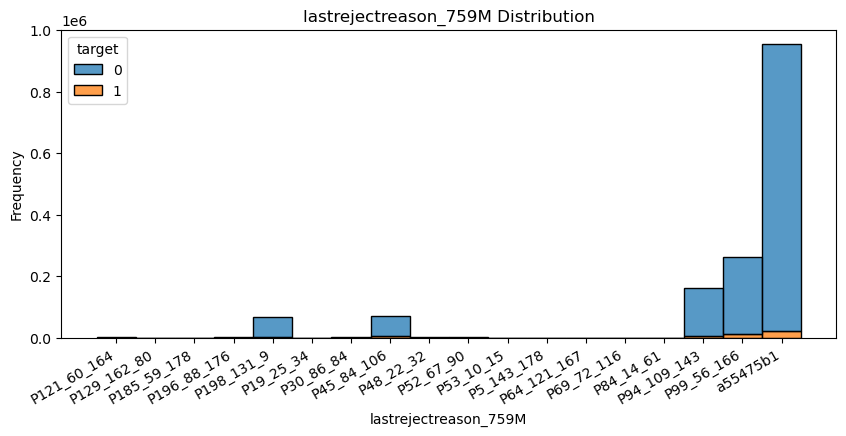

===lastrejectreasonclient_4145040M===
a55475b1:: 0_num = 953374, 1_num = 21973, per = 0.02304759407368559
P94_109_143:: 0_num = 462246, 1_num = 23182, per = 0.05015067701899634
P129_162_80:: 0_num = 6511, 1_num = 420, per = 0.0644963144963145
P30_86_84:: 0_num = 30446, 1_num = 1422, per = 0.04670410877919007
P5_143_178:: 0_num = 673, 1_num = 67, per = 0.09940652818991098
P84_14_61:: 0_num = 3239, 1_num = 110, per = 0.033950617283950615
P19_25_34:: 0_num = 875, 1_num = 6, per = 0.00684931506849315
P53_10_15:: 0_num = 192, 1_num = 13, per = 0.06735751295336788
P52_67_90:: 0_num = 11636, 1_num = 393, per = 0.03377159061613818
P64_121_167:: 0_num = 1224, 1_num = 164, per = 0.13387755102040816
P69_72_116:: 0_num = 8243, 1_num = 244, per = 0.029597282872392043
P59_114_135:: 0_num = 2, 1_num = 0, per = 0.0
P204_22_168:: 0_num = 2, 1_num = 0, per = 0.0
P203_151_99:: 0_num = 2, 1_num = 0, per = 0.0


C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


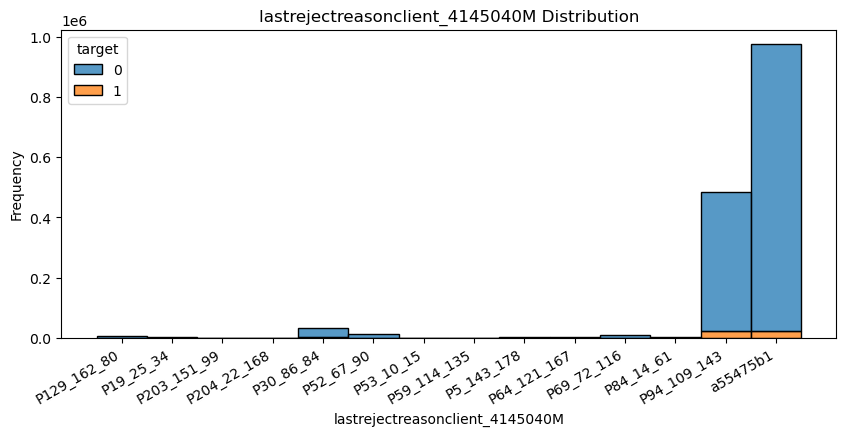

===previouscontdistrict_112M===
a55475b1:: 0_num = 473875, 1_num = 14553, per = 0.030710565633203624
P205_129_155:: 0_num = 1343, 1_num = 41, per = 0.03050595238095238
P131_33_167:: 0_num = 58457, 1_num = 1942, per = 0.03322043176297513
P91_101_191:: 0_num = 5517, 1_num = 213, per = 0.038600942370424066
P97_120_185:: 0_num = 3522, 1_num = 131, per = 0.037184217996026114
P141_13_175:: 0_num = 3898, 1_num = 188, per = 0.04821749166452936
P121_51_168:: 0_num = 5020, 1_num = 254, per = 0.0505875323640709
P76_152_180:: 0_num = 10140, 1_num = 443, per = 0.04368405482694014
P49_46_174:: 0_num = 1929, 1_num = 83, per = 0.043005181347150256
P114_147_118:: 0_num = 4807, 1_num = 176, per = 0.036605657237936774
P11_36_178:: 0_num = 7043, 1_num = 287, per = 0.04074389551391255
P149_82_178:: 0_num = 767, 1_num = 36, per = 0.046875
P98_137_111:: 0_num = 31261, 1_num = 1065, per = 0.0340669183033715
P179_96_159:: 0_num = 3731, 1_num = 76, per = 0.020364415862808145
P111_125_171:: 0_num = 12158, 1_num 

P79_138_178:: 0_num = 2312, 1_num = 81, per = 0.03501945525291829
P85_130_149:: 0_num = 7800, 1_num = 169, per = 0.021663889244968593
P37_46_141:: 0_num = 896, 1_num = 40, per = 0.044593088071348944
P182_70_81:: 0_num = 371, 1_num = 14, per = 0.03763440860215054
P169_111_32:: 0_num = 2239, 1_num = 88, per = 0.039285714285714285
P108_34_171:: 0_num = 1295, 1_num = 40, per = 0.030864197530864196
P40_155_168:: 0_num = 1661, 1_num = 97, per = 0.05836341756919374
P165_156_178:: 0_num = 2479, 1_num = 85, per = 0.034274193548387094
P152_70_56:: 0_num = 12103, 1_num = 564, per = 0.04659616655651024
P214_86_174:: 0_num = 13087, 1_num = 292, per = 0.02231051344743276
P111_148_100:: 0_num = 623, 1_num = 20, per = 0.03205128205128205
P171_42_169:: 0_num = 2774, 1_num = 110, per = 0.03963963963963964
P197_62_142:: 0_num = 2812, 1_num = 76, per = 0.0270174191254888
P24_125_177:: 0_num = 1559, 1_num = 43, per = 0.027564102564102563
P183_57_177:: 0_num = 5054, 1_num = 177, per = 0.035014836795252226
P

C:\Users\ki123\AppData\Local\Temp\ipykernel_22784\3525244849.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")


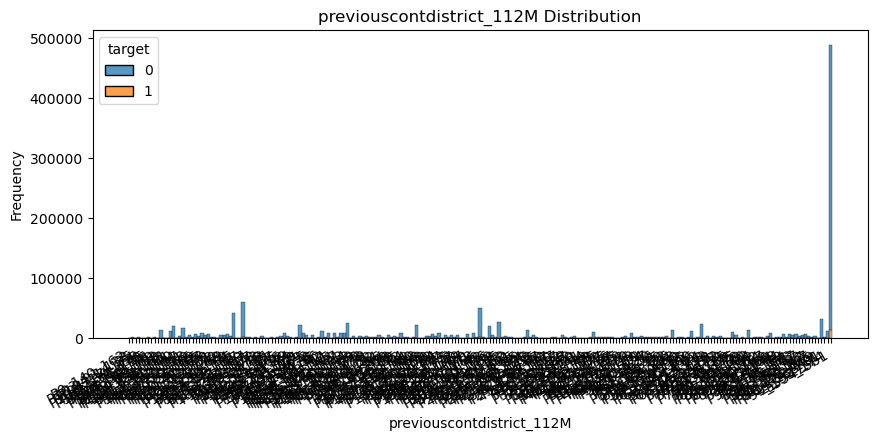

In [182]:
# 改良版
def plot_count_pairs(train, test, feature, hue="set"):
    df = train[['target',feature]].copy()
    # カウント数の記載
    for c in df[feature].unique():
        temp = df[df[feature] == c]
        print(f'{c}:: 0_num = {len(temp[temp["target"] == 0])}, 1_num = {len(temp[temp["target"] == 1])}, per = {len(temp[temp["target"] == 1])/(len(temp[temp["target"] == 0])+1)}')
    
    f, ax = plt.subplots(1, 1, figsize=(10, 4))
    sns.histplot(data=df, x=feature, bins=30, multiple="stack", kde=False, hue='target')
    ax.set_title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30, ha="right")
    plt.show()
    
    

for feature in features['categorical_features']:
    if feature == "target": continue
    print(f'==={feature}===')
    plot_count_pairs(train, test, feature)
#     break

### Numerical features

In [131]:
train[features['numerical_features']].nunique()

pmtaverage_3A                    40002
pmtaverage_4527227A              30526
pmtaverage_4955615A              32267
pmtssum_45A                     265229
annuity_780A                     75325
annuitynextmonth_57A             66202
credamount_770A                 183502
currdebt_22A                    363802
currdebtcredtyperange_828A      235536
disbursedcredamount_1113A       202398
downpmt_116A                     10042
inittransactionamount_650A       46692
lastapprcredamount_781A         129485
lastotherinc_902A                  101
lastotherlnsexpense_631A           232
lastrejectcredamount_222A        76040
maininc_215A                      7738
maxannuity_159A                 351075
maxannuity_4075009A               4621
price_1097A                     173566
sumoutstandtotal_3546847A       363369
sumoutstandtotalest_4493215A    252286
totaldebt_9A                    363903
totalsettled_863A               747166
dtype: int64

In [132]:
train.describe()

,case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,...,max_last180dayaveragebalance_704A,max_last180dayturnover_1134A,max_last30dayturnover_651A,max_openingdate_857D,max_num_group1_10,max_pmts_dpdvalue_108P,max_pmts_pmtsoverdue_635A,max_pmts_date_1107D,max_num_group1_11,max_num_group2
count,1.526659e+06,1.526659e+06,1.526659e+06,1.526659e+06,1.526659e+06,136996.000000,114978.000000,71633.000000,607871.000000,1.573290e+05,...,11289.000000,1.027200e+04,10272.000000,105087.000000,111772.000000,3.641500e+04,36415.000000,36447.000000,36447.000000,36447.000000
mean,1.286077e+06,4.076904e+01,3.143728e-02,6.425584e+00,3.984014e+00,-2368.489496,13.945155,-2837.152974,-16065.771127,6.416044e+05,...,118.227329,4.034088e+04,5345.528562,-1541.167280,0.407347,6.331363e+04,36.426704,-11.851181,1.246961,22.241419
std,7.189466e+05,2.379798e+01,1.744964e-01,3.512803e+00,1.988480e+00,2316.350761,0.410493,1962.589538,5108.123925,9.803273e+05,...,987.545689,4.210666e+04,19907.937900,448.678936,0.986336,1.267210e+06,1547.789956,18.043296,1.322809,12.829507
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-16454.000000,7.000000,-13040.000000,-27774.000000,0.000000e+00,...,-308.794130,-1.877800e+05,-477.506000,-6376.000000,0.000000,0.000000e+00,0.000000,-1003.000000,0.000000,0.000000
25%,7.661975e+05,2.300000e+01,0.000000e+00,3.000000e+00,2.000000e+00,-3409.000000,14.000000,-3971.000000,-20251.000000,7.853195e+04,...,0.000000,1.000000e+04,0.000000,-1887.000000,0.000000,0.000000e+00,0.000000,-19.000000,0.000000,10.000000
50%,1.357358e+06,4.000000e+01,0.000000e+00,7.000000e+00,4.000000e+00,-1850.000000,14.000000,-2489.000000,-15434.000000,3.072824e+05,...,0.000000,3.000000e+04,0.000000,-1539.000000,0.000000,0.000000e+00,0.000000,-11.000000,1.000000,24.000000
75%,1.739022e+06,5.500000e+01,0.000000e+00,9.000000e+00,6.000000e+00,-610.000000,14.000000,-1344.000000,-11720.000000,8.021141e+05,...,1.662000,6.000000e+04,0.000000,-1195.000000,1.000000,2.105700e+04,2.600000,-3.000000,2.000000,35.000000
max,2.703454e+06,9.100000e+01,1.000000e+00,1.200000e+01,7.000000e+00,14.000000,14.000000,4.000000,-7656.000000,3.129676e+07,...,67777.770000,1.161820e+06,390000.000000,-524.000000,65.000000,1.851242e+08,147470.610000,14.000000,20.000000,36.000000


In [133]:
test.describe()

,case_id,WEEK_NUM,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,...,max_last180dayaveragebalance_704A,max_last180dayturnover_1134A,max_last30dayturnover_651A,max_openingdate_857D,max_num_group1_10,max_pmts_dpdvalue_108P,max_pmts_pmtsoverdue_635A,max_pmts_date_1107D,max_num_group1_11,max_num_group2
count,10.000000,10.0,10.0,10.000000,0.0,0.0,5.000000,0.0,3.000000,9.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,57592.400000,92.0,10.0,2.100000,NaN,NaN,-2799.400000,NaN,257668.573333,-18319.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,42.253731,0.0,0.0,0.316228,NaN,NaN,1784.838312,NaN,427272.994575,7670.709208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,57543.000000,92.0,10.0,2.000000,NaN,NaN,-5592.000000,NaN,0.000000,-26395.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,57551.250000,92.0,10.0,2.000000,NaN,NaN,-3141.000000,NaN,11065.130000,-24538.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,57599.500000,92.0,10.0,2.000000,NaN,NaN,-2734.000000,NaN,22130.260000,-22194.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,57631.750000,92.0,10.0,2.000000,NaN,NaN,-1504.000000,NaN,386502.860000,-11024.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,57634.000000,92.0,10.0,3.000000,NaN,NaN,-1026.000000,NaN,750875.460000,-8832.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


===pmtaverage_3A===


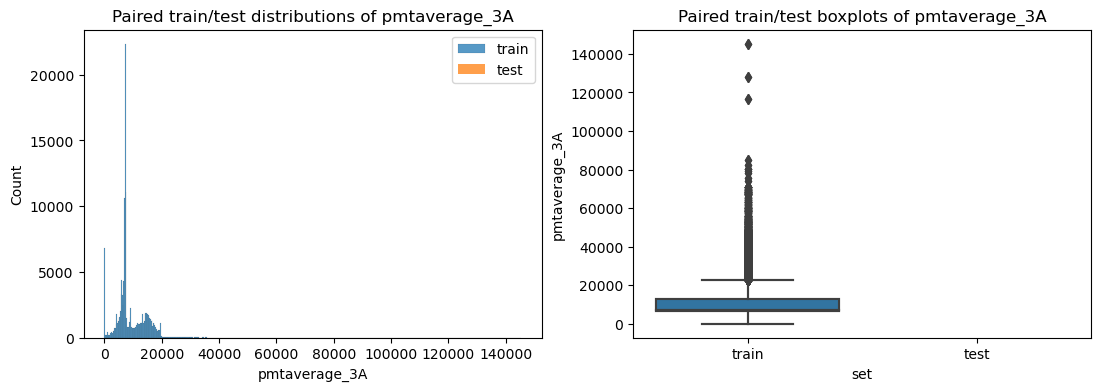

===pmtaverage_4527227A===


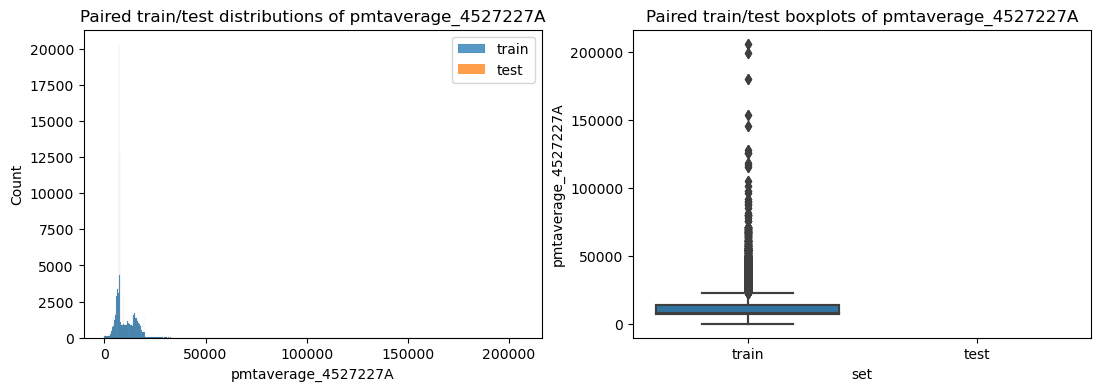

===pmtaverage_4955615A===


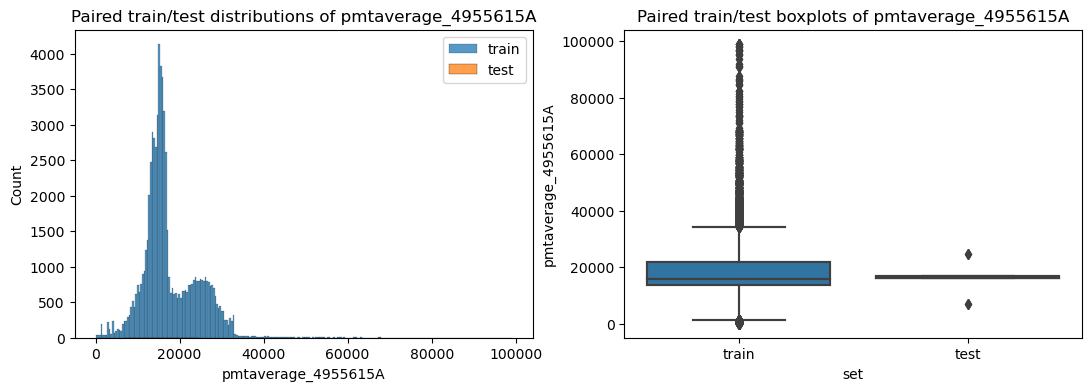

===pmtssum_45A===


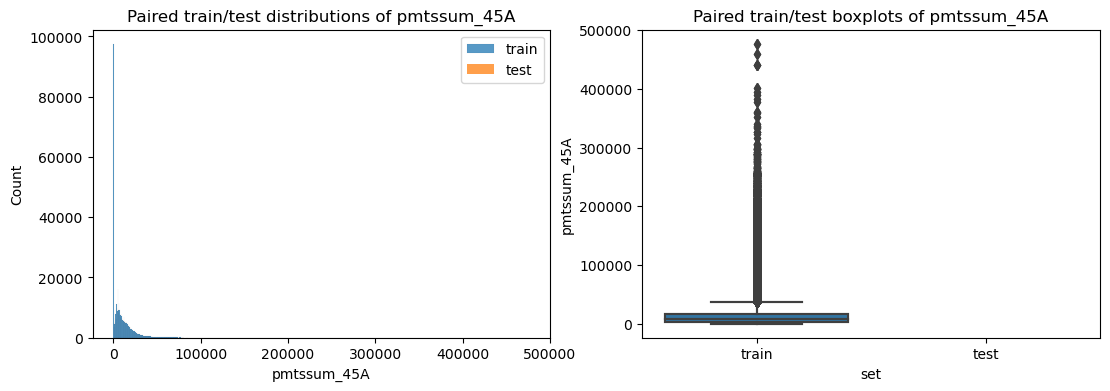

===annuity_780A===


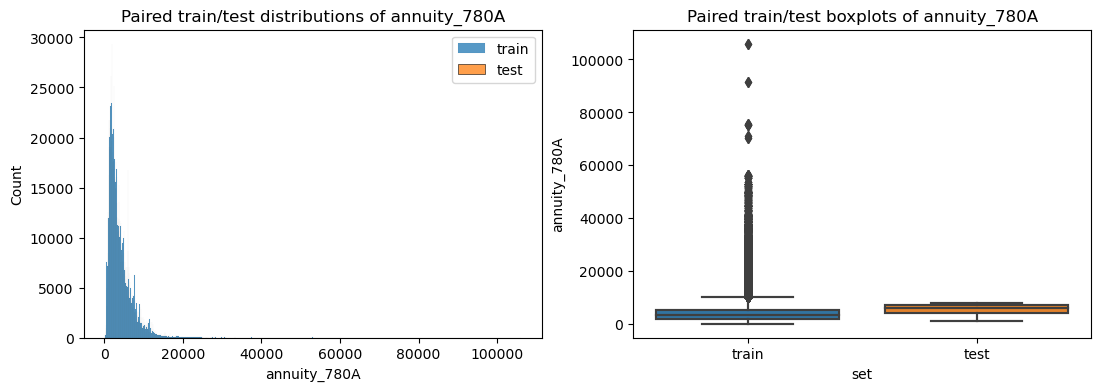

===annuitynextmonth_57A===


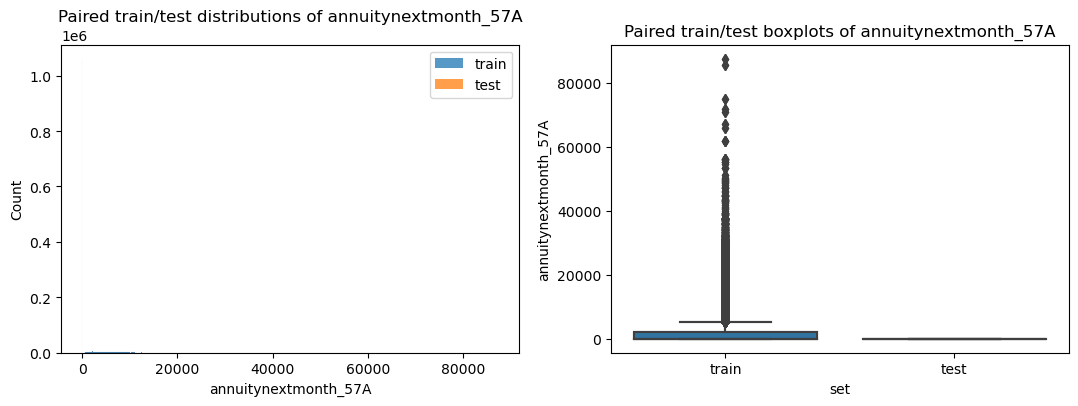

===credamount_770A===


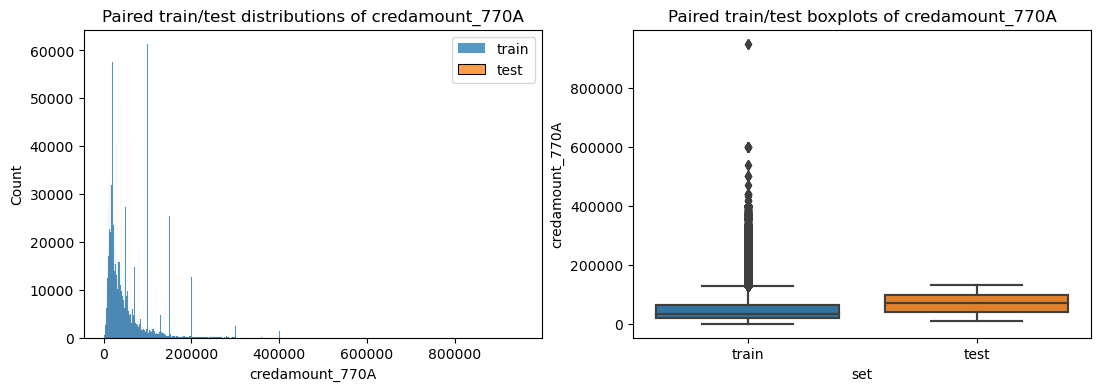

===currdebt_22A===


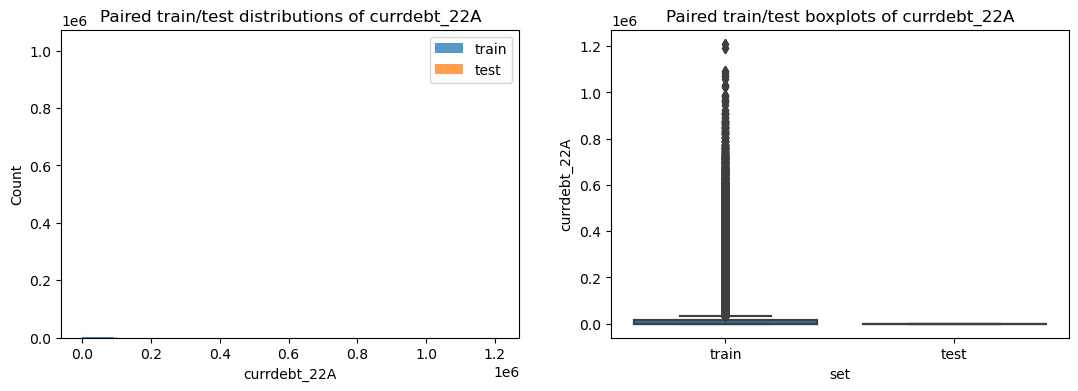

===currdebtcredtyperange_828A===


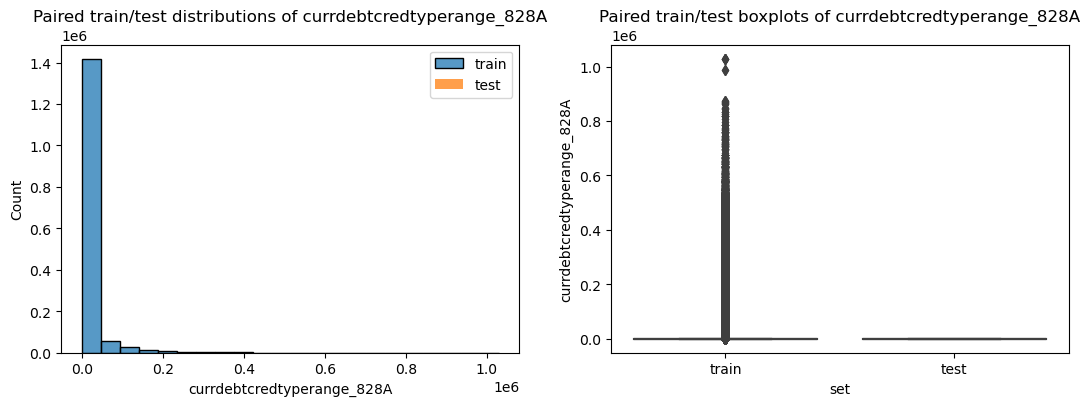

===disbursedcredamount_1113A===


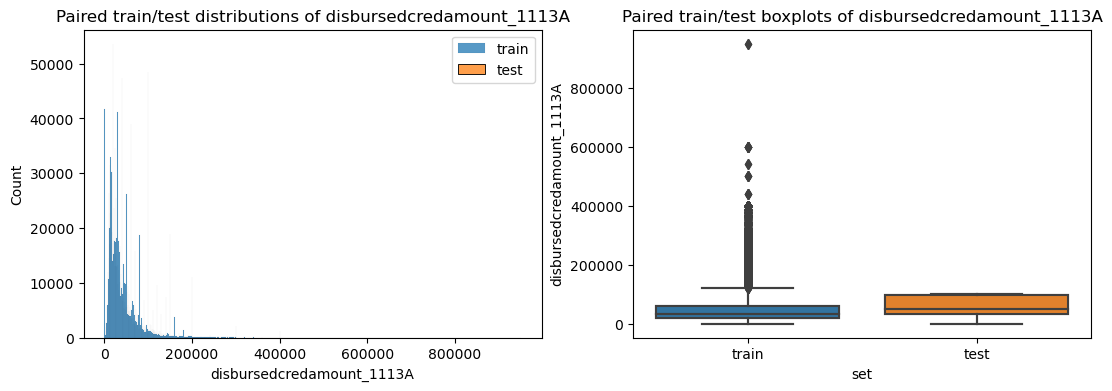

===downpmt_116A===


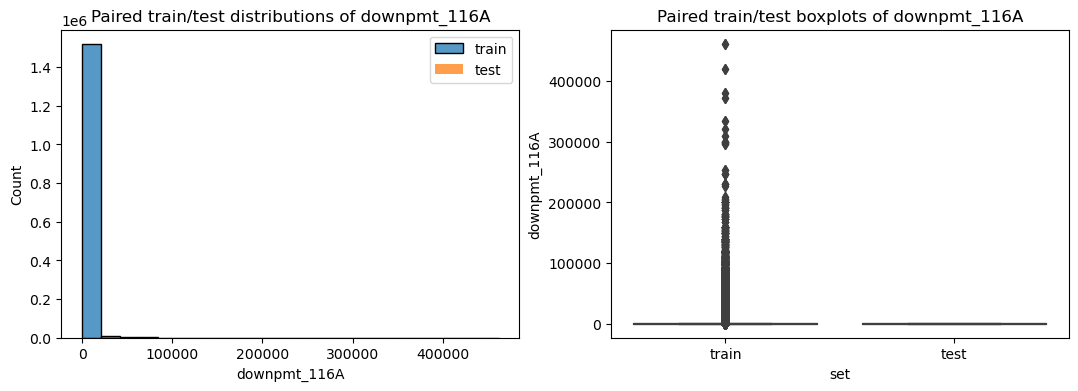

===inittransactionamount_650A===


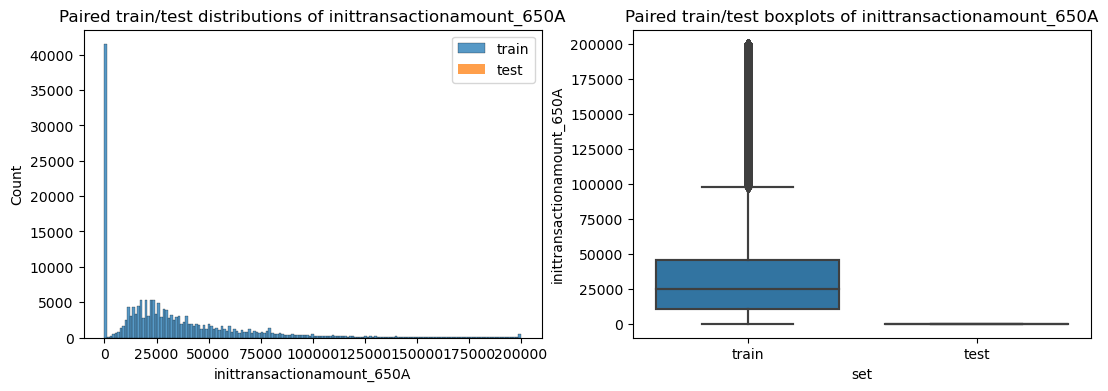

===lastapprcredamount_781A===


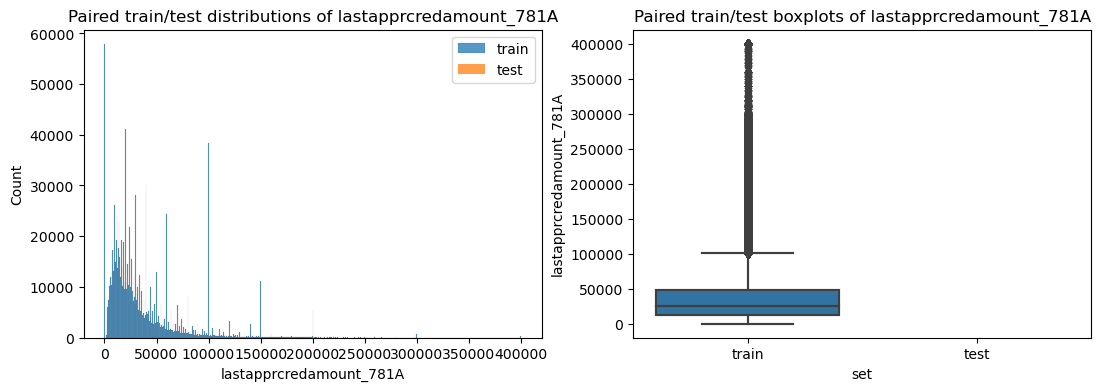

===lastotherinc_902A===


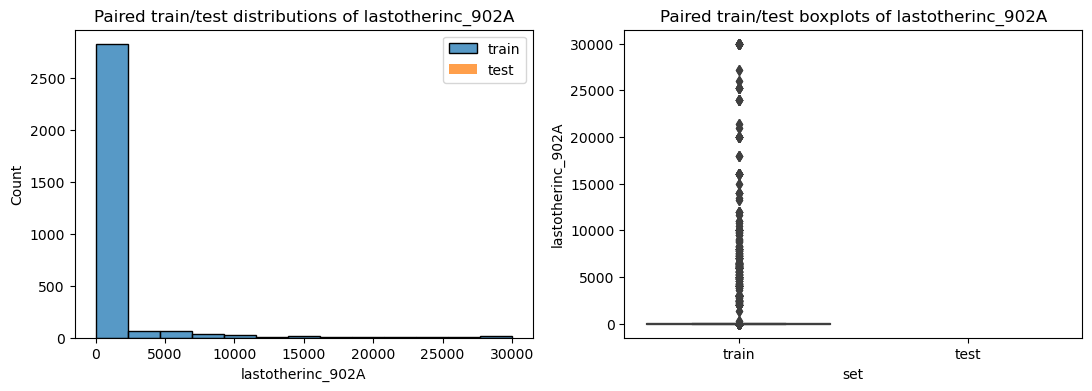

===lastotherlnsexpense_631A===


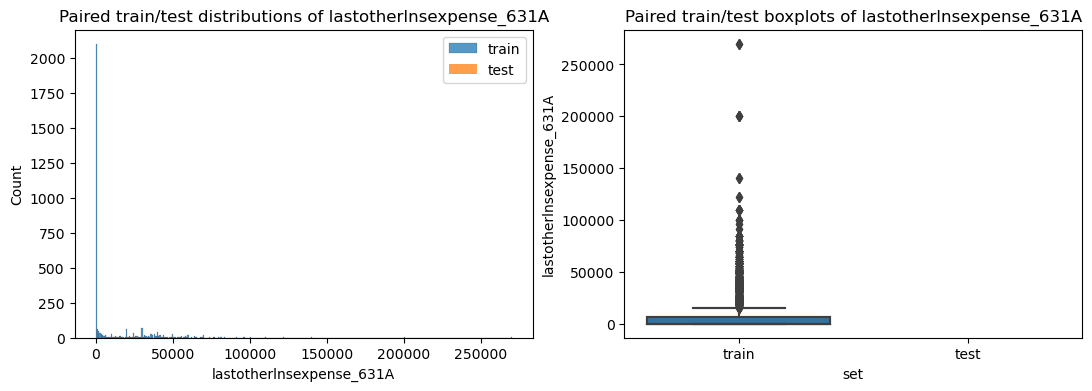

===lastrejectcredamount_222A===


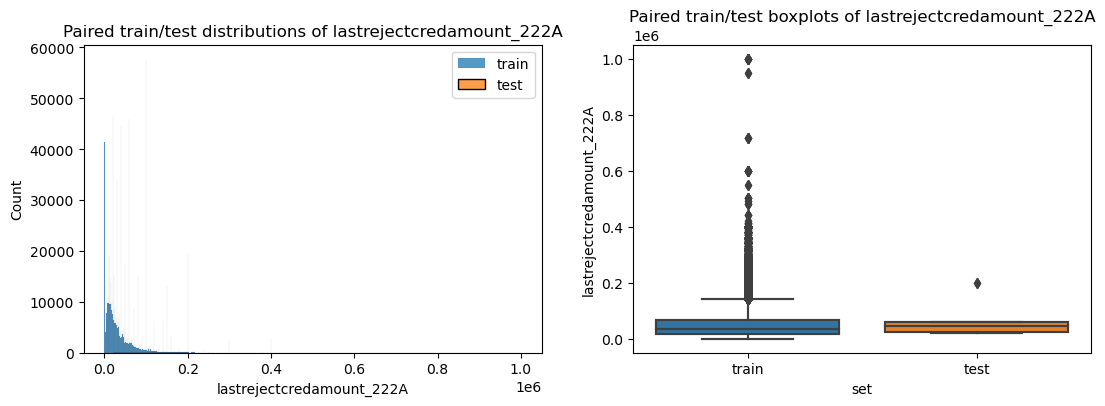

===maininc_215A===


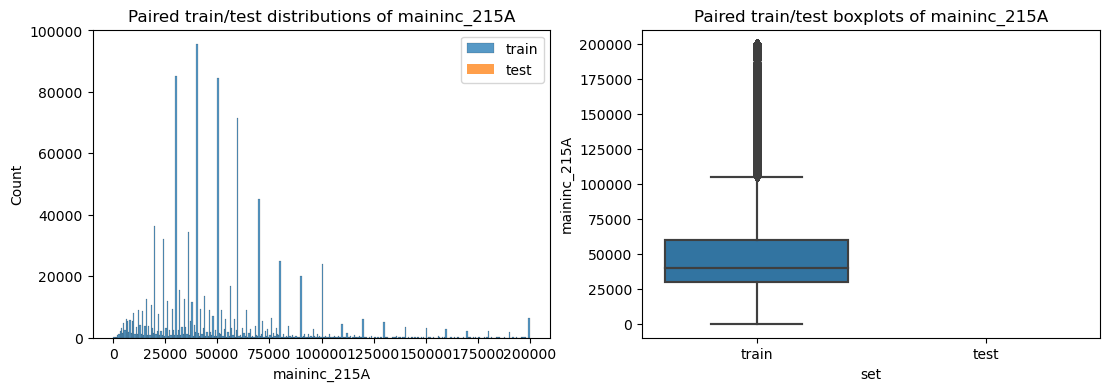

===maxannuity_159A===


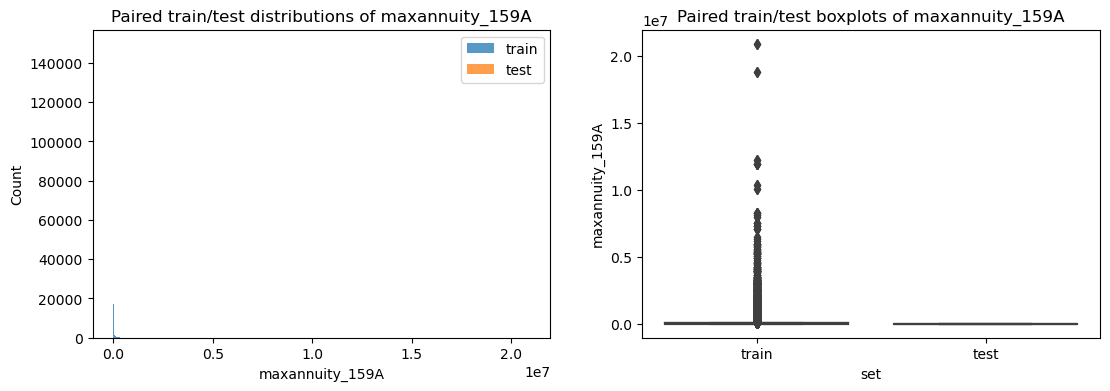

===maxannuity_4075009A===


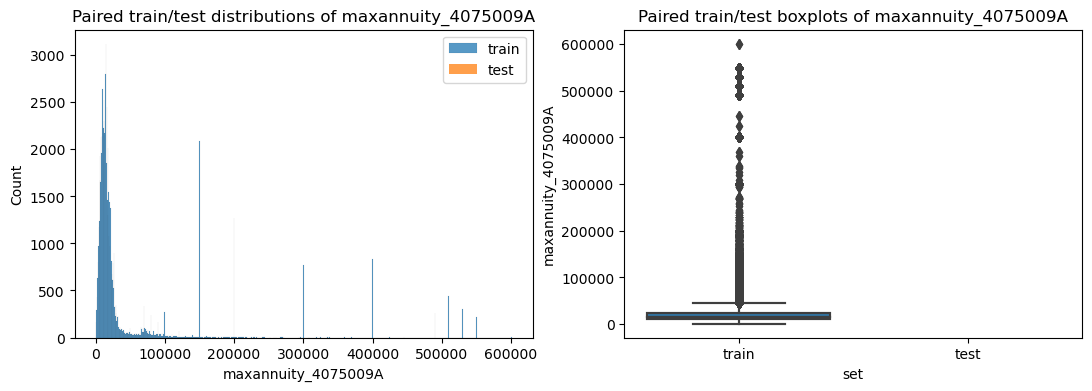

===price_1097A===


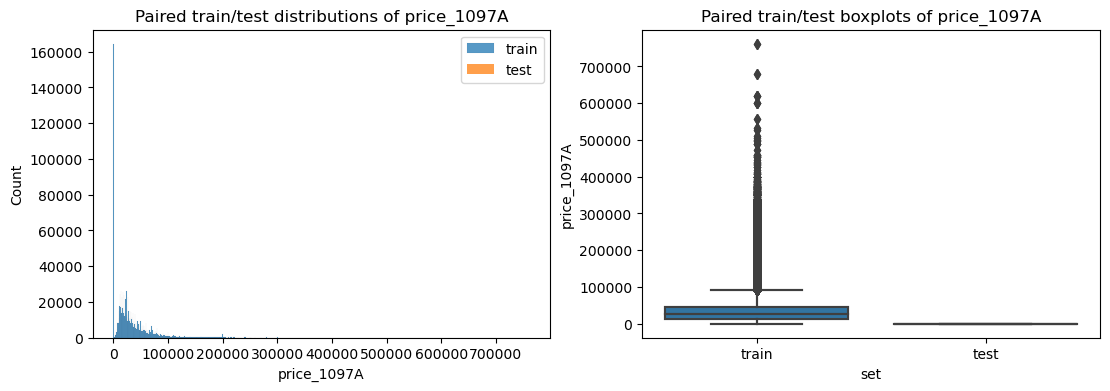

===sumoutstandtotal_3546847A===


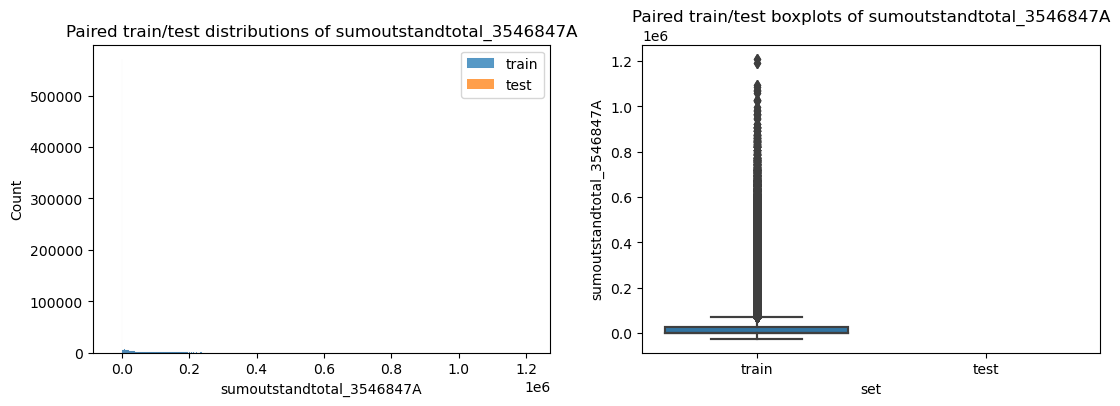

===sumoutstandtotalest_4493215A===


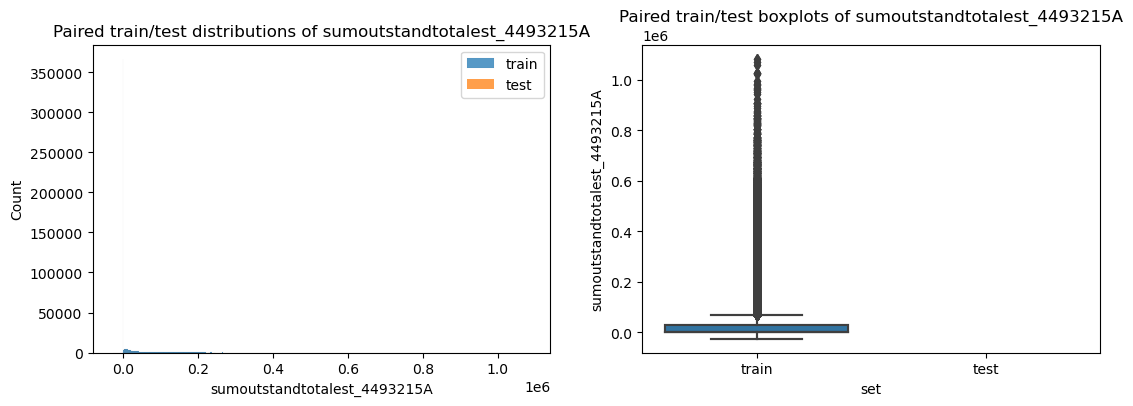

===totaldebt_9A===


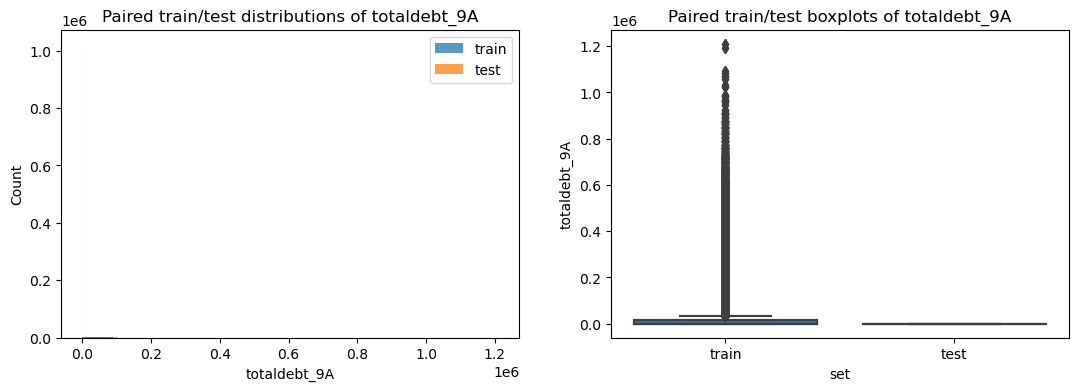

===totalsettled_863A===


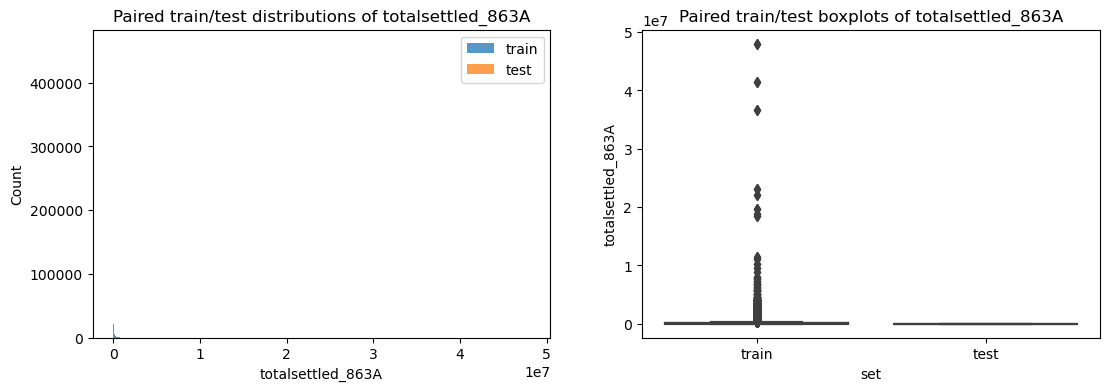

In [138]:
# 原文
def plot_distribution_pairs(train, test, feature, hue="set", palette=None):
    df = train[[feature]].copy()
    df["set"] = "train"    
    df = pd.concat([df, test[[feature]].copy()])
    df['set'] = df['set'].fillna("test")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(13,4))
    for i, s in enumerate(df[hue].unique()):
        selection = df.loc[df[hue]==s, feature]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            g_hist = sns.histplot(selection, ax=ax[0], label=s)
            g_box = sns.boxplot(x=hue, y=feature, data=df, ax=ax[1])
    
    ax[0].set_title(f"Paired train/test distributions of {feature}")
    ax[1].set_title(f"Paired train/test boxplots of {feature}")
    
    g_hist.legend()
    plt.show()

for feature in features['numerical_features']:
    print(f'==={feature}===')
    plot_distribution_pairs(train, test, feature)

### Feature engineering

In [32]:
all_df.select_dtypes(include=["object"]).columns

NameError: name 'all_df' is not defined

In [20]:
feature_dict = {}
for col in features['categorical_features']:
    print(col)
    d_temp = {}
    for cc,v in enumerate(train[col].unique()):
        d_temp[v] = cc
    feature_dict[col] = d_temp

description_5085714M
education_1103M
education_88M
maritalst_385M
maritalst_893M
requesttype_4525192L
riskassesment_302T
bankacctype_710L
cardtype_51L
credtype_322L
disbursementtype_67L
equalitydataagreement_891L
equalityempfrom_62L
inittransactioncode_186L
isbidproductrequest_292L
isdebitcard_729L
lastapprcommoditycat_1041M
lastapprcommoditytypec_5251766M
lastcancelreason_561M
lastrejectcommoditycat_161M
lastrejectcommodtypec_5251769M
lastrejectreason_759M
lastrejectreasonclient_4145040M
lastst_736L
opencred_647L
paytype1st_925L
paytype_783L
previouscontdistrict_112M
twobodfilling_608L
typesuite_864L
max_cancelreason_3545846M
max_district_544M
max_education_1138M
max_postype_4733339M
max_profession_152M
max_rejectreason_755M
max_rejectreasonclient_4145042M
max_credacc_status_367L
max_credtype_587L
max_familystate_726L
max_inittransactioncode_279L
max_isbidproduct_390L
max_isdebitcard_527L
max_status_219L
max_name_4527232M
max_name_4917606M
max_employername_160M
max_classificationofcon

In [34]:
feature_dict

{'description_5085714M': {nan: 0, 'a55475b1': 1, '2fc785b2': 2},
 'education_1103M': {nan: 0,
  'a55475b1': 1,
  '717ddd49': 2,
  '6b2ae0fa': 3,
  '39a0853f': 4,
  'c8e1a1d0': 5},
 'education_88M': {nan: 0,
  'a55475b1': 1,
  '6b2ae0fa': 2,
  '717ddd49': 3,
  'a34a13c8': 4,
  'c8e1a1d0': 5},
 'maritalst_385M': {nan: 0,
  'a55475b1': 1,
  'a7fcb6e5': 2,
  '3439d993': 3,
  'b6cabe76': 4,
  '38c061ee': 5,
  'ecd83604': 6},
 'maritalst_893M': {nan: 0,
  'a55475b1': 1,
  '46b968c3': 2,
  '977b2a70': 3,
  '1a19667c': 4,
  'e18430ff': 5,
  'ecd83604': 6},
 'lastapprcommoditycat_1041M': {'a55475b1': 0,
  'P159_130_59': 1,
  'P21_79_33': 2,
  'P12_6_178': 3,
  'P109_133_183': 4,
  'P53_45_92': 5,
  'P148_110_5': 6,
  'P33_29_177': 7,
  'P201_79_148': 8,
  'P100_96_175': 9,
  'P216_109_183': 10,
  'P143_21_170': 11,
  'P187_118_47': 12,
  'P128_43_169': 13,
  'P177_46_174': 14,
  'P105_126_172': 15,
  'P184_3_97': 16,
  'P121_6_80': 17,
  'P160_128_10': 18,
  'P65_94_74': 19,
  'P110_120_162': 2

In [21]:
# feature_dict = {
#     "Gender": {
#         'Female': 0,
#         'Male': 1 
#     },
#     "family_history_with_overweight": {
#         'no': 0,
#         'yes': 1 
#     },
#     "FAVC": {
#         'no': 0,
#         'yes': 1 
#     },
#     "CAEC": {
#         'no': 0, 
#         'Sometimes': 1, 
#         'Frequently': 2, 
#         'Always': 3
#     },
#     "SMOKE": {
#         'no': 0, 
#         'yes': 1
#     },
#     "SCC": {
#         'no': 0, 
#         'yes': 1
#     },
#     "CALC": {
#         'no': 0,
#         'Sometimes': 1,
#         'Frequently': 2,
#         "Always": 3,
#     },
# }

target_categories = [0, 1]

obesity_dict = {label: numeric for numeric, label in enumerate(target_categories)}
inverse_obesity_dict = {numeric: label for numeric, label in enumerate(target_categories)}

In [36]:
pd.concat([train, test], keys=[0, 1], axis=0)

case_id  WEEK_NUM  target  month_decision  weekday_decision  \
0 0        0         0     0.0               1                 4   
  1        1         0     0.0               1                 4   
  2        2         0     0.0               1                 5   
  3        3         0     0.0               1                 4   
  4        4         0     1.0               1                 5   
..       ...       ...     ...             ...               ...   
1 5    57630        92     NaN              10                 2   
  6    57631        92     NaN              10                 2   
  7    57632        92     NaN              10                 2   
  8    57633        92     NaN              10                 2   
  9    57634        92     NaN              10                 2   

     assignmentdate_238D  assignmentdate_4527235D  assignmentdate_4955616D  \
0 0                  NaN                      NaN                      NaN   
  1                  NaN                      NaN                      NaN   
  2                  NaN                      NaN                      NaN   
  3                  NaN                      NaN                      NaN   
  4                  NaN                      NaN                      NaN   
..                   ...                      ...                      ...   
1 5                  NaN                      NaN                      NaN   
  6                  NaN                      NaN                  -2734.0   
  7                  NaN                      NaN                  -1504.0   
  8                  NaN                      NaN                      NaN   
  9                  NaN                      NaN                  -1026.0   

     birthdate_574D  contractssum_5085716L  ...  \
0 0             NaN                    NaN  ...   
  1             NaN                    NaN  ...   
  2             NaN                    NaN  ...   
  3             NaN                    NaN  ...   
  4             NaN                    NaN  ...   
..              ...                    ...  ...   
1 5             NaN                    NaN  ...   
  6             NaN              750875.46  ...   
  7             NaN                    NaN  ...   
  8             NaN                   0.00  ...   
  9             NaN                    NaN  ...   

     max_last180dayaveragebalance_704A  max_last180dayturnover_1134A  \
0 0                                NaN                           NaN   
  1                                NaN                           NaN   
  2                                NaN                           NaN   
  3                                NaN                           NaN   
  4                                NaN                           NaN   
..                                 ...                           ...   
1 5                                NaN                           NaN   
  6                                NaN                           NaN   
  7                                NaN                           NaN   
  8                                NaN                           NaN   
  9                                NaN                           NaN   

     max_last30dayturnover_651A  max_openingdate_857D  max_num_group1_10  \
0 0                         NaN                   NaN                NaN   
  1                         NaN                   NaN                NaN   
  2                         NaN                   NaN                NaN   
  3                         NaN                   NaN                NaN   
  4                         NaN                   NaN                NaN   
..                          ...                   ...                ...   
1 5                         NaN                   NaN                NaN   
  6                         NaN                   NaN                NaN   
  7                         NaN                   NaN                NaN   
  8          

In [19]:
all_df = pd.concat([train, test], keys=[0, 1], axis=0)
for feature in features['categorical_features']:
    if feature == "MTRANS":
        df_onehot = pd.get_dummies(all_df[feature])
        all_df = pd.concat([all_df, df_onehot], axis=1)
        all_df.drop(columns=[feature], inplace=True)
    else:
        all_df[feature] = all_df[feature].map(feature_dict[feature])

# 修正方法がわからないから力業(strな項が残る)
feature_dict2 = {}
for col in all_df.select_dtypes(include=["object","category"]).columns:
    d_temp = {}
    for cc,v in enumerate(train[col].unique()):
        d_temp[v] = cc
    feature_dict2[col] = d_temp

for feature in all_df.select_dtypes(include=["object","category"]).columns:
    all_df[feature] = all_df[feature].map(feature_dict2[feature])

train3 = all_df.xs(0).copy()
test3 = all_df.xs(1).copy()
target3 = target.map(obesity_dict)

NameError: name 'test' is not defined

In [24]:
# 改良版
all_df = train.copy()
for feature in features['categorical_features']:
    all_df[feature] = all_df[feature].map(feature_dict[feature])

# 修正方法がわからないから力業(strな項が残る)
feature_dict2 = {}
for col in all_df.select_dtypes(include=["object","category"]).columns:
    d_temp = {}
    for cc,v in enumerate(train[col].unique()):
        d_temp[v] = cc
    feature_dict2[col] = d_temp

for feature in all_df.select_dtypes(include=["object","category"]).columns:
    all_df[feature] = all_df[feature].map(feature_dict2[feature])

train3 = all_df.copy()
# test3 = all_df.xs(1).copy()
target3 = target.map(obesity_dict)

In [30]:
train3

,case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,...,max_last180dayaveragebalance_704A,max_last180dayturnover_1134A,max_last30dayturnover_651A,max_openingdate_857D,max_num_group1_10,max_pmts_dpdvalue_108P,max_pmts_pmtsoverdue_635A,max_pmts_date_1107D,max_num_group1_11,max_num_group2
0,0,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,1,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,1,1,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,91,0,10,1,NaN,NaN,-998.0,NaN,52863.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526655,2703451,91,0,10,1,NaN,NaN,-5591.0,NaN,324608.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526656,2703452,91,0,10,1,NaN,NaN,NaN,NaN,102738.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526657,2703453,91,0,10,1,NaN,NaN,-4616.0,NaN,212683.29,...,NaN,NaN,NaN,-1956.0,1.0,NaN,NaN,NaN,NaN,NaN


In [38]:
train3.dtypes

case_id                        int64
WEEK_NUM                       int64
target                       float64
month_decision                  int8
weekday_decision                int8
                              ...   
max_pmts_dpdvalue_108P       float64
max_pmts_pmtsoverdue_635A    float64
max_pmts_date_1107D          float64
max_num_group1_11            float64
max_num_group2               float64
Length: 376, dtype: object

In [93]:
train3.select_dtypes(include=["object","category"]).columns

Index(['max_contaddr_matchlist_1032L', 'max_isreference_387L',
       'max_remitter_829L'],
      dtype='object')

In [94]:
train3['max_contaddr_matchlist_1032L']

0          0
1          0
2          0
3          0
4          0
          ..
1526654    0
1526655    0
1526656    0
1526657    0
1526658    0
Name: max_contaddr_matchlist_1032L, Length: 1526659, dtype: category
Categories (1, int64): [0]

In [41]:
train3.head().T

,0,1,2,3,4
case_id,0,1,2,3,4
WEEK_NUM,0,0,0,0,0
target,0.0,0.0,0.0,0.0,1.0
month_decision,1,1,1,1,1
weekday_decision,4,4,5,4,5
...,...,...,...,...,...
max_pmts_dpdvalue_108P,NaN,NaN,NaN,NaN,NaN
max_pmts_pmtsoverdue_635A,NaN,NaN,NaN,NaN,NaN
max_pmts_date_1107D,NaN,NaN,NaN,NaN,NaN
max_num_group1_11,NaN,NaN,NaN,NaN,NaN


In [42]:
test3.head().T

,0,1,2,3,4
case_id,57543,57549,57551,57552,57569
WEEK_NUM,92,92,92,92,92
target,NaN,NaN,NaN,NaN,NaN
month_decision,10,10,10,10,10
weekday_decision,2,2,2,3,2
...,...,...,...,...,...
max_pmts_dpdvalue_108P,NaN,NaN,NaN,NaN,NaN
max_pmts_pmtsoverdue_635A,NaN,NaN,NaN,NaN,NaN
max_pmts_date_1107D,NaN,NaN,NaN,NaN,NaN
max_num_group1_11,NaN,NaN,NaN,NaN,NaN


In [31]:
for cc,i in enumerate(train3.columns):
    if train3.dtypes.iloc[cc] == 'category':
        print(i)
        train3[i] = train3[i].astype('float64')

max_contaddr_matchlist_1032L
max_contaddr_smempladdr_334L
max_isreference_387L
max_remitter_829L
max_safeguarantyflag_411L


In [99]:
train3.corrwith(target)

AttributeError: 'float' object has no attribute 'shape'

In [44]:
corr = train3.corrwith(target).abs().sort_values(ascending=False)

In [45]:
corr

target                             1.000000
riskassesment_940T                 0.180037
pctinstlsallpaidlate1d_3546856L    0.125055
pctinstlsallpaidlate4d_3546849L    0.122669
pctinstlsallpaidlate6d_3546844L    0.119374
                                     ...   
max_remitter_829L                       NaN
max_role_1084L                          NaN
max_role_993L                           NaN
max_sex_738L                            NaN
max_type_25L                            NaN
Length: 376, dtype: float64

In [46]:
corr.to_csv('../dataset/corr_v1.csv',encoding='cp932')

In [132]:
type(train3.iloc[0,-1])

numpy.float64

In [96]:
for i in range(train3.shape[1]):
    print(i,train3.iloc[:,i].max())

0 2703454
1 91
2 1.0
3 12
4 7
5 14.0
6 14.0
7 4.0
8 -7656.0
9 31296759.11
10 -58.0
11 -1837.0
12 109.0
13 110.0
14 22.0
15 115.0
16 41.0
17 nan
18 5
19 5
20 76.0
21 1.0
22 57.0
23 2.0
24 0.0
25 1.0
26 11.0
27 2.0
28 0.0
29 19.0
30 2.0
31 1.0
32 4.0
33 0.0
34 1.0
35 2.0
36 41.0
37 66.0
38 6
39 6
40 115.0
41 145257.4
42 205848.61
43 99085.4
44 15.0
45 16.0
46 66.0
47 121.0
48 476843.4
49 nan
50 14.0
51 14.0
52 14.0
53 nan
54 2.1191318
55 109.0
56 62.0
57 4206.0
58 1408010.2
59 106007.0
60 87500.0
61 5.0
62 28.0
63 728.0
64 247.0
65 90.0
66 287.0
67 4750.0
68 4750.0
69 4750.0
70 4750.0
71 496148.8
72 513520.0
73 240.0
74 1131135.9
75 495910.4
76 nan
77 2
78 198.0
79 112.0
80 175.0
81 109.0
82 266.0
83 24.0
84 35.0
85 4.0
86 390.0
87 13.0
88 510.0
89 15.0
90 922.0
91 12.0
92 1242.0
93 72.0
94 575.0
95 25.0
96 0.0
97 950000.0
98 3
99 1210629.1
100 1029392.8
101 13.0
102 -26.0
103 13.0
104 5337.0
105 0.0
106 950000.0
107 3
108 461867.4
109 13.0
110 0.45
111 1.0
112 1.0
113 14.0
114 47.0
115 

In [32]:
drop_cols = []
for i in train3.columns:
    if train3[i].max() == 0:
        drop_cols.append(i)
        print(i)

formonth_118L
forquarter_462L
forweek_601L
commnoinclast6m_3546845L
deferredmnthsnum_166L
interestrategrace_34L
mastercontrelectronic_519L
mastercontrexist_109L
max_num_group1_7
max_contaddr_matchlist_1032L
max_remitter_829L


In [120]:
train4 = train3.drop(drop_cols,axis=1)

In [34]:
for cc,i in enumerate(train3.columns):
    print(i)
    print(train3.iloc[:,cc:cc+1].corrwith(target).values)
    print()

case_id
[0.00383365]

WEEK_NUM
[0.00296921]

target
[1.]

month_decision
[-0.00351407]

weekday_decision
[-0.0134311]

assignmentdate_238D
[0.00732654]

assignmentdate_4527235D
[-0.00462418]

assignmentdate_4955616D
[0.00445681]

birthdate_574D
[0.05344614]

contractssum_5085716L
[0.00837443]

dateofbirth_337D
[0.05221038]

dateofbirth_342D
[0.10870332]

days120_123L
[0.07394509]

days180_256L
[0.07330559]

days30_165L
[0.06243589]

days360_512L
[0.06444648]

days90_310L
[0.07231995]

description_5085714M
[nan]

education_1103M
[nan]

education_88M
[nan]

firstquarter_103L
[0.03691084]

for3years_128L
[-0.00232889]

for3years_504L
[0.05562009]

for3years_584L
[0.00199648]

formonth_118L
[nan]

formonth_206L
[-0.00484864]

formonth_535L
[0.07399297]

forquarter_1017L
[-0.00395986]

forquarter_462L
[nan]

forquarter_634L
[0.08358541]

fortoday_1092L
[0.02670623]

forweek_1077L
[-0.00190151]

forweek_528L
[0.04260404]

forweek_601L
[nan]

foryear_618L
[-0.00190151]

foryear_818L
[-0.00395

[0.02224807]

max_cancelreason_3545846M
[nan]

max_district_544M
[nan]

max_education_1138M
[nan]

max_postype_4733339M
[nan]

max_profession_152M
[nan]

max_rejectreason_755M
[nan]

max_rejectreasonclient_4145042M
[nan]

max_byoccupationinc_3656910L
[-0.00694522]

max_childnum_21L
[-0.00438287]

max_credacc_status_367L
[nan]

max_credacc_transactions_402L
[0.00901403]

max_credtype_587L
[nan]

max_familystate_726L
[nan]

max_inittransactioncode_279L
[nan]

max_isbidproduct_390L
[nan]

max_isdebitcard_527L
[nan]

max_pmtnum_8L
[0.04612319]

max_status_219L
[nan]

max_tenor_203L
[0.04612319]

max_num_group1
[0.02293449]

max_amount_4527230A
[-0.0447722]

max_recorddate_4527225D
[-0.01835427]

max_name_4527232M
[nan]

max_num_group1_3
[-0.04543172]

max_amount_4917619A
[-0.03292693]

max_deductiondate_4917603D
[-0.02063254]

max_name_4917606M
[nan]

max_num_group1_4
[-0.03579355]

max_pmtamount_36A
[-0.03605153]

max_processingdate_168D
[-0.01652437]

max_employername_160M
[nan]

max_num

In [33]:
for cc,i in enumerate(train4.columns):
    print(i)
    print(train4.iloc[:,cc:cc+1].corrwith(target).values)
    print()

NameError: name 'train4' is not defined

In [147]:
train4[train4['max_isreference_387L'] > 0]['max_isreference_387L']

6          1
22         1
157        1
246        1
356        1
          ..
1525733    1
1525747    1
1525792    1
1526134    1
1526330    1
Name: max_isreference_387L, Length: 12458, dtype: Int64

In [149]:
train4['max_housingtype_772L']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1526654    0.0
1526655    0.0
1526656    0.0
1526657    0.0
1526658    0.0
Name: max_housingtype_772L, Length: 1526659, dtype: float64

In [133]:
train4 = train4.replace(pd.NA, np.nan)

In [140]:
train4 = train4.fillna(0)

### Model

In [29]:
del train3

NameError: name 'train3' is not defined

In [25]:
X = train3.copy()
y = target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [153]:
X = train3
y = target
X_test = test3
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
def fit_plot(model, X_train, y_train, X_val, y_val, verbose=100):
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(X_train, y_train, eval_set=eval_set, verbose=verbose)
    
    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_val = accuracy_score(y_val, model.predict(X_val))
    print(f"train_accuracy: {acc_train:.4f}\ntest_accuracy: {acc_val:.4f}")
    
    results = model.evals_result()
    val_mlogloss = results["validation_1"]["mlogloss"]
    best_epopch = min(val_mlogloss)
    i_best_epoch = val_mlogloss.index(best_epopch)
    print(f"Best mlogloss: {best_epopch}\nBest epoch: {i_best_epoch}")
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)
    
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
    ax.plot(i_best_epoch, best_epopch, marker="o", color="green", label="Best")
    ax.legend()
    plt.xlabel("Epochs")
    plt.ylabel("M Log Loss")
    plt.title("M Log Loss developement while fitting")
    plt.show()

#### baseline model

In [45]:
xgb_0 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    early_stopping_rounds=50,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    colsample_bytree=0.8,
    subsample=0.8,
    objective= 'accuracy',
    eval_metric = 'mlogloss',
    nthread=-1,
    random_state=42
)
fit_plot(xgb_0, X_train, y_train, X_val, y_val)

XGBoostError: [17:59:57] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\objective.cc:27: Unknown objective function: `accuracy`
Objective candidate: rank:ndcg
Objective candidate: rank:pairwise
Objective candidate: rank:map
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: reg:quantileerror
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:linear
Objective candidate: reg:pseudohubererror
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:gamma
Objective candidate: reg:tweedie
Objective candidate: reg:absoluteerror


In [26]:
import lightgbm as lgb

In [27]:
X = train3.copy()
y = target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
type(X)

pandas.core.frame.DataFrame

In [52]:
XX = train3.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

fitted_models = []

for idx_train, idx_valid in cv.split(XX, y, groups=weeks):
    print(type(XX))
    X_train, y_train = XX.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = XX.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)

model = VotingModel(fitted_models)

<class 'pandas.core.frame.DataFrame'>


AttributeError: 'Series' object has no attribute 'iloc'

In [14]:
X = train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = train["target"]
weeks = train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
}

fitted_models = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)

model = VotingModel(fitted_models)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.810237
[200]	valid_0's auc: 0.815887
[300]	valid_0's auc: 0.816994
[400]	valid_0's auc: 0.817136
Early stopping, best iteration is:
[397]	valid_0's auc: 0.817202
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.811608
[200]	valid_0's auc: 0.816657
[300]	valid_0's auc: 0.817148
Early stopping, best iteration is:
[272]	valid_0's auc: 0.817269
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.81663
[200]	valid_0's auc: 0.822959
[300]	valid_0's auc: 0.824629
[400]	valid_0's auc: 0.824818
Early stopping, best iteration is:
[348]	valid_0's auc: 0.824892
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.817245
[200]	valid_0's auc: 0.822332
[300]	valid_0's auc: 0.823319
[400]	valid_0's auc: 0.823359
Early stopping, best iteration is:
[309]	valid_0's auc: 0.823513
Training until validation scores don't impr

In [ ]:
train, cat_cols = to_pandas(df_train)

In [29]:
X = train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = train["target"]
weeks = train["WEEK_NUM"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
}

model = lgb.LGBMClassifier(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.814984
[200]	valid_0's auc: 0.82047
[300]	valid_0's auc: 0.82134
[400]	valid_0's auc: 0.821508
Early stopping, best iteration is:
[386]	valid_0's auc: 0.821577


LGBMClassifier(colsample_bynode=0.8, colsample_bytree=0.8, learning_rate=0.05,
               max_depth=8, metric='auc', n_estimators=1000, objective='binary',
               random_state=42, verbose=-1)

In [52]:
train.dtypes.unique()

array([dtype('int64'), dtype('int8'), dtype('float64'),
       CategoricalDtype(categories=['2fc785b2', 'a55475b1'], ordered=False),
       CategoricalDtype(categories=['39a0853f', '6b2ae0fa', '717ddd49', 'a55475b1', 'c8e1a1d0'], ordered=False),
       CategoricalDtype(categories=['6b2ae0fa', '717ddd49', 'a34a13c8', 'a55475b1', 'c8e1a1d0'], ordered=False),
       CategoricalDtype(categories=['3439d993', '38c061ee', 'a55475b1', 'a7fcb6e5', 'b6cabe76',
                         'ecd83604'],
       , ordered=False)                                                                        ,
       CategoricalDtype(categories=['1a19667c', '46b968c3', '977b2a70', 'a55475b1', 'e18430ff',
                         'ecd83604'],
       , ordered=False)                                                                        ,
       CategoricalDtype(categories=['DEDUCTION_6', 'PENSION_6', 'SOCIAL_6'], ordered=False),
       CategoricalDtype(categories=['1% - 1%', '11% - 15%', '15% - 19%', '2% - 2%', '2

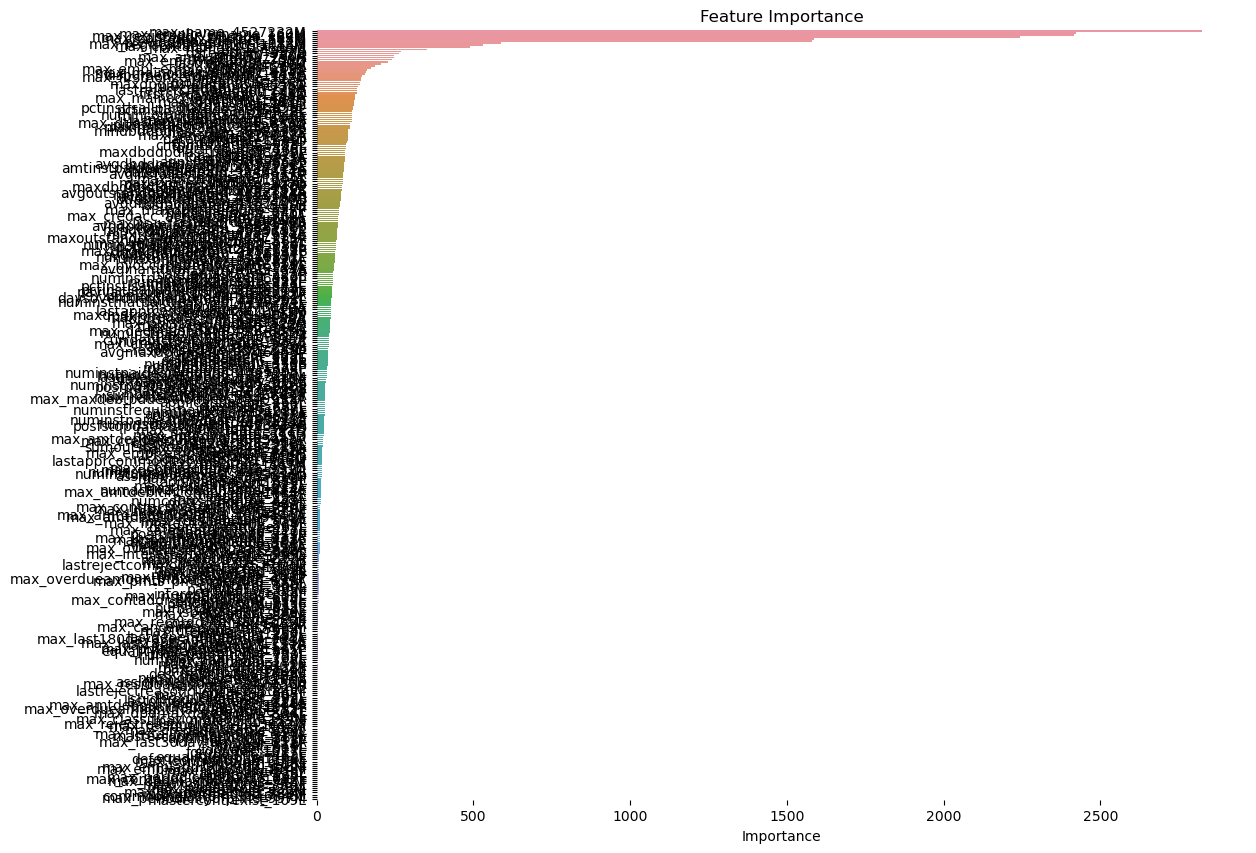

In [18]:
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

In [23]:
df_feature_importance = pd.DataFrame([list(X_train.columns),feature_importance])

In [35]:
a = pd.Series(list(X_train.columns),name="column_name")
b = pd.Series(list(feature_importance),name="feature_importance")
df_feature_importance = pd.merge(a,b,left_on = a.index,right_on=b.index)
df_feature_importance

ValueError: Unable to fill values because RangeIndex cannot contain NA

In [48]:
feature_importance_df.to_csv('../dataset/feature_importance.csv',encoding='cp932',index=False)

,Feature,Importance
263,max_name_4527232M,2826
271,max_employername_160M,2423
334,max_registaddr_zipcode_184M,2417
328,max_contaddr_zipcode_807M,2244
242,max_district_544M,1586
...,...,...
302,max_purposeofcred_722M,0
301,max_pmtmethod_731M,0
93,commnoinclast6m_3546845L,0
300,max_periodicityofpmts_997M,0


In [24]:
df_feature_importance

,0,1,2,3,4,5,6,7,8,9,...,363,364,365,366,367,368,369,370,371,372
0,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,dateofbirth_342D,days120_123L,...,max_last180dayaveragebalance_704A,max_last180dayturnover_1134A,max_last30dayturnover_651A,max_openingdate_857D,max_num_group1_10,max_pmts_dpdvalue_108P,max_pmts_pmtsoverdue_635A,max_pmts_date_1107D,max_num_group1_11,max_num_group2
1,67,73,23,2,16,99,67,268,23,84,...,4,4,0,22,3,7,7,8,3,25


In [19]:
feature_importance

array([  67,   73,   23,    2,   16,   99,   67,  268,   23,   84,  101,
         92,  128,   91,    2,   45,    6,   76,    0,    9,    0,    0,
          0,    5,    0,    0,    5,    2,    0,    2,    0,    0,    0,
          7,   92,   16,    0,   50,   89,   86,   65,    3,    4,   17,
         53,  204,   42,   17,   37,   17,   36,   72,   85,   98,    9,
         87,  264,   25,    0,    8,   25,   27,   15,   89,   88,   75,
         59,   67,   85,   54,   37,   79,   77,   10,    1,   19,   11,
          9,    7,   15,    8,    4,    0,   13,    4,    5,    7,    1,
         10,   27,   13,   59,   94,    0,  132,   15,   49,   39,  101,
         83,   86,   48,    0,  155,   10,   42,   76,  119,    3,    0,
        127,  118,   36,  107,    9,   57,    6,   34,    1,    0,   74,
        112,   45,   17,   80,   67,   30,  112,    4,    3,    1,   33,
          8,  130,  226,   38,    2,    8,   27,  141,    0,    0,  123,
         46,   91,   82,   60,   89,   45,  139,   

In [52]:
feature_importance = xgb_0.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

NotFittedError: need to call fit or load_model beforehand

### SHAP

In [2]:
import numpy as np

In [22]:
train, cat_cols = to_pandas(df_train)

In [28]:
display(list(train.drop(columns=["target", "case_id", "WEEK_NUM"]).columns))

['month_decision',
 'weekday_decision',
 'assignmentdate_238D',
 'assignmentdate_4527235D',
 'assignmentdate_4955616D',
 'birthdate_574D',
 'contractssum_5085716L',
 'dateofbirth_337D',
 'dateofbirth_342D',
 'days120_123L',
 'days180_256L',
 'days30_165L',
 'days360_512L',
 'days90_310L',
 'description_5085714M',
 'education_1103M',
 'education_88M',
 'firstquarter_103L',
 'for3years_128L',
 'for3years_504L',
 'for3years_584L',
 'formonth_118L',
 'formonth_206L',
 'formonth_535L',
 'forquarter_1017L',
 'forquarter_462L',
 'forquarter_634L',
 'fortoday_1092L',
 'forweek_1077L',
 'forweek_528L',
 'forweek_601L',
 'foryear_618L',
 'foryear_818L',
 'foryear_850L',
 'fourthquarter_440L',
 'maritalst_385M',
 'maritalst_893M',
 'numberofqueries_373L',
 'pmtaverage_3A',
 'pmtaverage_4527227A',
 'pmtaverage_4955615A',
 'pmtcount_4527229L',
 'pmtcount_4955617L',
 'pmtcount_693L',
 'pmtscount_423L',
 'pmtssum_45A',
 'requesttype_4525192L',
 'responsedate_1012D',
 'responsedate_4527233D',
 'respon

In [14]:
X = train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = train["target"]
weeks = train["WEEK_NUM"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
}

model = lgb.LGBMClassifier(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.814984
[200]	valid_0's auc: 0.82047
[300]	valid_0's auc: 0.82134
[400]	valid_0's auc: 0.821508
Early stopping, best iteration is:
[386]	valid_0's auc: 0.821577


LGBMClassifier(colsample_bynode=0.8, colsample_bytree=0.8, learning_rate=0.05,
               max_depth=8, metric='auc', n_estimators=1000, objective='binary',
               random_state=42, verbose=-1)

In [15]:
# shap.Explainer()にモデルを渡す
explainer = shap.Explainer(model)

In [16]:
# explainerインスタンスに説明変数(特徴量)を渡す
shap_values = explainer(X_train)

In [18]:
X_train.shape

(1221327, 373)

In [20]:
shap_values.values.shape

(1221327, 373)

In [32]:
np.savetxt('../dataset/shap_values.txt', shap_values.values)

In [3]:
a = np.loadtxt('../dataset/shap_values.txt')

In [4]:
b = np.abs(a).mean(axis=0)

In [8]:
np.savetxt('../dataset/shap_values_abs_mean.txt', b)

In [6]:
b.shape

(373,)

In [22]:
shap_values.base_values.shape

(1221327,)

In [17]:
shap_values

.values =
array([[ 2.12864690e-02,  2.94805090e-02, -3.62535027e-05, ...,
         8.00886871e-06, -8.08292942e-06,  2.13553295e-04],
       [ 7.48158241e-03,  3.69909152e-02, -1.37048895e-05, ...,
         8.25680642e-06, -8.08292942e-06,  2.46388985e-04],
       [ 7.37755355e-03, -1.58025273e-02, -2.10827500e-05, ...,
         8.53959628e-06, -1.56815601e-06,  1.29079779e-04],
       ...,
       [-8.80437590e-03,  1.93315292e-02, -1.68583516e-05, ...,
         8.53959628e-06, -1.15880588e-06,  2.01616549e-04],
       [ 1.20802003e-02, -2.94467592e-02, -3.56358449e-05, ...,
         8.00886871e-06, -4.29764793e-06,  2.46388985e-04],
       [-9.81831293e-03,  2.23453222e-02, -1.47992359e-05, ...,
         8.25680642e-06, -1.56815601e-06,  2.13152162e-04]])

.base_values =
array([-4.13966714, -4.13966714, -4.13966714, ..., -4.13966714,
       -4.13966714, -4.13966714])

.data =
array([[1, 3, nan, ..., nan, nan, nan],
       [4, 3, nan, ..., nan, nan, nan],
       [5, 5, nan, ..., nan, n

In [23]:
# SHAP値を確認したいレコードのインデックス
target_record_index = 0
shap.plots.waterfall(shap_values[target_record_index])

KeyboardInterrupt: 

In [24]:
shap.summary_plot(shap_values, X_train)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000015349281800> (for post_execute):


KeyboardInterrupt: 

### Optuna

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

In [47]:
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 1, 20) 
    min_child_weight = trial.suggest_float("min_child_weight", 10, 30)
    gamma = trial.suggest_float("gamma", 1e-8, 1, log=True)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0, 1)
    subsample = trial.suggest_float("subsample", 0, 1)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-8, 10, log=True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-8, 10, log=True)
     
    params = {
        "learning_rate": learning_rate,
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "min_child_weight": min_child_weight,
        "gamma": gamma,
        "colsample_bytree": colsample_bytree,
        "subsample": subsample,
        "reg_alpha": reg_alpha,  
        "reg_lambda": reg_lambda,      
    }

    params["eval_metric"] = 'mlogloss'
    params["objective"] = "multi:softprob"
    params["nthread"] = -1
    params["random_state"] = 42
    
    model = XGBClassifier(**params)
    scorer = make_scorer(accuracy_score)
    cv_splits = cv.split(X_train, y=y_train)
    scores = cross_validate(model, X_train, y_train, cv=cv_splits, scoring=scorer)
    accuracy = np.mean(scores['test_score'])
       
    return accuracy

cv = StratifiedKFold(5, shuffle=True, random_state=42)

sampler = TPESampler(seed=42)
study = optuna.create_study(directions=["maximize"], sampler=sampler)
study.optimize(objective, n_trials=100)
study_df = study.trials_dataframe()
study_best = study_df.sort_values(by='value', ascending=False)
best_params = study.best_params
print(best_params)

[I 2024-03-14 19:16:19,856] A new study created in memory with name: no-name-aa5f7820-cbc7-426c-888d-8fa8082bbd7d
[W 2024-03-14 19:16:19,860] Trial 0 failed with parameters: {'learning_rate': 0.05611516415334506, 'n_estimators': 956, 'max_depth': 15, 'min_child_weight': 21.973169683940732, 'gamma': 1.77071686435378e-07, 'colsample_bytree': 0.15599452033620265, 'subsample': 0.05808361216819946, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598} because of the following error: NameError("name 'X_train' is not defined").
Traceback (most recent call last):
  File "C:\Users\ki123\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\ki123\AppData\Local\Temp\ipykernel_24628\3912342970.py", line 31, in objective
    cv_splits = cv.split(X_train, y=y_train)
                         ^^^^^^^
NameError: name 'X_train' is not defined
[W 2024-03-14 19:16:19,862] Trial 0 f

NameError: name 'X_train' is not defined

In [ ]:
best_params ={
    'learning_rate': 0.025712050975722187,
    'n_estimators': 558,
    'max_depth': 19,
    'min_child_weight': 11.692175971190222,
    'gamma': 0.40432112145823784,
    'colsample_bytree': 0.46430548509054603,
    'subsample': 0.8210990373796265,
    'reg_alpha': 3.768397197231378e-05,
    'reg_lambda': 1.3981775427791863
}
best_params["objective"] = "multi:softprob"
best_params["eval_metric"] = 'mlogloss'
best_params["early_stopping_rounds"] = 50
best_params["nthread"] = -1
best_params["random_state"] = 42

In [ ]:
study_best.head()

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
params = ["learning_rate", "n_estimators", "max_depth", "min_child_weight", "gamma", "colsample_bytree", "subsample", "reg_alpha", "reg_lambda"]
optuna.visualization.plot_slice(study, params=params)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
xgb_1 = XGBClassifier(**best_params)
fit_plot(xgb_1, X_train, y_train, X_val, y_val)

In [ ]:
feature_importance = xgb_1.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

# 不要なセル

## Feature Elimination

In [34]:
# ここでカラムの選定を行っている
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"]) # df_trainとカラムをそろえる

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 267)
test data shape:	 (10, 266)


In [13]:
"target" in list(df_train.columns)

True

## Pandas Conversion

In [27]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

## Garbage Collection

In [28]:
del data_store

gc.collect()

197

## EDA

In [29]:
print("Train is duplicated:\t", df_train["case_id"].duplicated().any()) # case_idが重複している行の確認
print("Train Week Range:\t", (df_train["WEEK_NUM"].min(), df_train["WEEK_NUM"].max())) # 週データの範囲を出力

print()

print("Test is duplicated:\t", df_test["case_id"].duplicated().any())
print("Test Week Range:\t", (df_test["WEEK_NUM"].min(), df_test["WEEK_NUM"].max()))

Train is duplicated:	 False
Train Week Range:	 (0, 91)

Test is duplicated:	 False
Test Week Range:	 (92, 92)


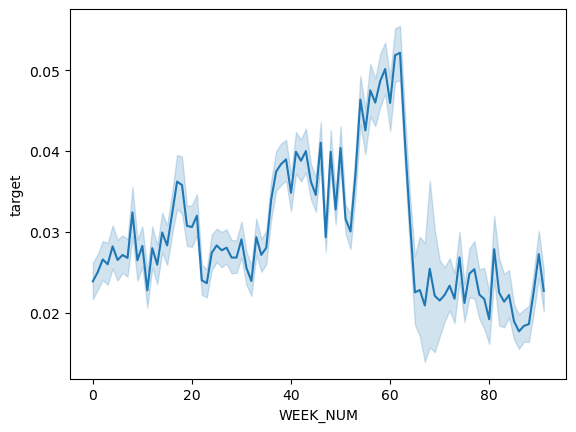

In [30]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

## Training

In [34]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

fitted_models = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model)

model = VotingModel(fitted_models)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.813977
[200]	valid_0's auc: 0.82321
[300]	valid_0's auc: 0.82645
[400]	valid_0's auc: 0.827376
[500]	valid_0's auc: 0.828061
[600]	valid_0's auc: 0.82853
[700]	valid_0's auc: 0.828813
[800]	valid_0's auc: 0.829039
[900]	valid_0's auc: 0.829242
[1000]	valid_0's auc: 0.829595
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.829602
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.815076
[200]	valid_0's auc: 0.823548
[300]	valid_0's auc: 0.826763
[400]	valid_0's auc: 0.827733
[500]	valid_0's auc: 0.828577
[600]	valid_0's auc: 0.828974
[700]	valid_0's auc: 0.829141
[800]	valid_0's auc: 0.829182
[900]	valid_0's auc: 0.829273
[1000]	valid_0's auc: 0.829399
Did not meet early stopping. Best iteration is:
[990]	valid_0's auc: 0.829449
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.820274
[200]	valid_0's auc: 0.829581

## Prediction

In [35]:
X_test = df_test.drop(columns=["WEEK_NUM"])
X_test = X_test.set_index("case_id")

y_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

## Submission

In [36]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred

In [37]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head()

Check null:  False


,score
case_id,
57543,0.194741
57549,0.115272
57551,0.081814
57552,0.084836
57569,0.056174


In [38]:
df_subm.to_csv("submission.csv")